# Spatial biodiversity modeling: PREDICTS data exploration

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as geopd
import polars as pl

from matplotlib.ticker import FuncFormatter, MaxNLocator
import time
import scipy

In [9]:
# Load black for formatting
import jupyter_black

jupyter_black.load()

In [10]:
# Load the complete data set
df_predicts = pl.read_csv("../../data/PREDICTS/merged_data.csv")

In [11]:
df_predicts.shape

(4318808, 68)

In [12]:
df_predicts.head()

shape: (5, 68)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ _id   ┆ Source_ID  ┆ Reference  ┆ Study_numb ┆ … ┆ Habitat_a ┆ Habitat_p ┆ Km_to_nea ┆ Years_sin │
│ ---   ┆ ---        ┆ ---        ┆ er         ┆   ┆ s_describ ┆ atch_area ┆ rest_edge ┆ ce_fragme │
│ i64   ┆ str        ┆ str        ┆ ---        ┆   ┆ ed        ┆ _square_m ┆ _of_habit ┆ ntation_o │
│       ┆            ┆            ┆ i64        ┆   ┆ ---       ┆ etr…      ┆ at        ┆ r_c…      │
│       ┆            ┆            ┆            ┆   ┆ str       ┆ ---       ┆ ---       ┆ ---       │
│       ┆            ┆            ┆            ┆   ┆           ┆ str       ┆ str       ┆ f64       │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 26004 ┆ AD1_2008__ ┆ Billeter   ┆ 8          ┆ … ┆ null      ┆ null      ┆ null      ┆ 13.5      │
│       ┆ Billeter   ┆ et al.     ┆            ┆   ┆           ┆           ┆           ┆           │
│       ┆            ┆ 2008       ┆            ┆   ┆           ┆           ┆           ┆           │
│ 26006 ┆ AD1_2008__ ┆ Billeter   ┆ 8          ┆ … ┆ null      ┆ null      ┆ null      ┆ 13.5      │
│       ┆ Billeter   ┆ et al.     ┆            ┆   ┆           ┆           ┆           ┆           │
│       ┆            ┆ 2008       ┆            ┆   ┆           ┆           ┆           ┆           │
│ 26024 ┆ AD1_2008__ ┆ Billeter   ┆ 8          ┆ … ┆ null      ┆ null      ┆ null      ┆ 63.5      │
│       ┆ Billeter   ┆ et al.     ┆            ┆   ┆           ┆           ┆           ┆           │
│       ┆            ┆ 2008       ┆            ┆   ┆           ┆           ┆           ┆           │
│ 26031 ┆ AD1_2008__ ┆ Billeter   ┆ 8          ┆ … ┆ null      ┆ null      ┆ null      ┆ 63.5      │
│       ┆ Billeter   ┆ et al.     ┆            ┆   ┆           ┆           ┆           ┆           │
│       ┆            ┆ 2008       ┆            ┆   ┆           ┆           ┆           ┆           │
│ 26032 ┆ AD1_2008__ ┆ Billeter   ┆ 8          ┆ … ┆ null      ┆ null      ┆ null      ┆ 63.5      │
│       ┆ Billeter   ┆ et al.     ┆            ┆   ┆           ┆           ┆           ┆           │
│       ┆            ┆ 2008       ┆            ┆   ┆           ┆           ┆           ┆           │
└───────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Basic data inspection

### Data scope and coverage 

In [15]:
# List with relevant information to display
labels = ["sampling locations", "countries", "species", "studies"]
columns = ["SSS", "Country", "Taxon_name_entered", "SS"]

# Print stats for each relevant column
print(f"{'Number of observations':<30} {df_predicts.shape[0]:,}")
for label, column in zip(labels, columns):
    count = df_predicts.select(pl.col(column).unique()).shape[0]
    print(f"Number of {label:<20} {count:,}")

Number of observations         4,318,808
Number of sampling locations   35,736
Number of countries            101
Number of species              53,925
Number of studies              817


### Proportion of missing values

In [16]:
# Print the % of missing values per column in Polars
for column in df_predicts.columns:
    missing_count = df_predicts.select(pl.col(column).null_count()).item()
    missing_percentage = missing_count / df_predicts.height * 100
    print(f"{column:<40} {missing_percentage:.1f}%")

_id                                      0.0%
Source_ID                                0.0%
Reference                                0.0%
Study_number                             0.0%
Study_name                               0.0%
Block                                    47.1%
Site_number                              0.0%
Site_name                                0.0%
SS                                       0.0%
SSS                                      0.0%
SSB                                      0.0%
SSBS                                     0.0%
Longitude                                0.0%
Latitude                                 0.0%
Coordinates_method                       0.0%
Country                                  0.0%
Country_distance_metres                  0.0%
UN_region                                0.0%
UN_subregion                             0.0%
Realm                                    0.0%
Biome                                    0.0%
Ecoregion                        

**Comment:** Good data coverage on most variables we want to use. There is quite a lot of missing data in the lowest levels of the taxonomy (genus and species). Also missing data on linear extent of many sites, which we want to use in the detection model. 

### Sampling methods

In [17]:
# Display all sampling methods
df_predicts.select("Sampling_method").unique().to_series().to_list()

['harp trap',
 'fall nets under trees',
 'reporting rates',
 'aerial nets',
 'suction samplers',
 'transects with baits',
 'soil cores along transects',
 'line transect distance sampling',
 'baited pit-fall traps',
 'mist-netting',
 'flower visitations',
 'litter collection',
 'tunnel trap',
 'visual encounter survey',
 'transect',
 'pan traps',
 'fern collection',
 'aerial flight-interception trap',
 'aerial flight-inception  trap',
 'malaise traps',
 'fixed plots/quadrats',
 'live traps',
 'baited traps',
 'multiple',
 'pitfall trap transects',
 'tvsp traps',
 'window traps',
 'mixed trap',
 'quadrats on transects',
 'sweep net',
 'call surveys',
 'camera traps',
 'sweep_netting',
 'point counts',
 'phytometer',
 'litter and twigs augmented',
 'soil sample',
 'litter augmented',
 'systematic searching',
 'pit-fall traps',
 'cylindrical gauze traps',
 'sweep netting',
 'bamboo twigs',
 'drift fences with traps',
 'plots/quadrats',
 'visual encounter survey and acoustic survey',
 'flow

### Number of taxa per site 

In [18]:
# Calculate number of species per unique site (groupby source-study-block-site)
# Taxon_name_entered is the only field that gives the correct count
taxa_per_site = (
    df_predicts.group_by("SSBS")
    .agg(pl.col("Taxon_name_entered").n_unique())
    .get_column("Taxon_name_entered")
)

print(f"{taxa_per_site.mean():.3f}")
print(taxa_per_site.min())
print(taxa_per_site.max())

120.853
1
1857


### Number of sites per study

In [19]:
# Calculate number of sites per study
# (groupby source-study, count source-study-block-site)
sites_per_study = (
    df_predicts.group_by("SS").agg(pl.col("SSBS").n_unique()).get_column("SSBS")
)

print(f"{sites_per_study.mean():.3f}")
print(sites_per_study.min())
print(sites_per_study.max())

43.741
2
754


### Number of blocks and sites per block


In [20]:
# Number of studies that contain blocks
num_block_studies = (
    df_predicts.filter(pl.col("Block").is_not_null())
    .select(pl.col("SS").n_unique())
    .item()
)

print(num_block_studies)

255


In [21]:
# Calculate number of sites per block, by filtering out studies with no block definitions
# (groupby source-study-block, count source-study-block-site)
sites_per_block = (
    df_predicts.filter(pl.col("Block").is_not_null())
    .group_by("SSB")
    .agg(pl.col("SSBS").n_unique())
    .get_column("SSBS")
)

print(f"{sites_per_block.mean():.3f}")
print(sites_per_block.min())
print(sites_per_block.max())

3.998
1
148


### Land use types and intensities

In [22]:
df_predicts.select("Predominant_land_use").unique().to_series().to_list()

['Intermediate secondary vegetation',
 'Primary vegetation',
 'Mature secondary vegetation',
 'Secondary vegetation (indeterminate age)',
 'Urban',
 'Young secondary vegetation',
 'Pasture',
 'Cannot decide',
 'Cropland',
 'Plantation forest']

In [23]:
# Percentage of "Cannot decide" land use types
perc_lulc_na = (
    df_predicts.filter(pl.col("Predominant_land_use") == "Cannot decide").height
    / df_predicts.height
    * 100
)
print(f"{perc_lulc_na:.2f}%")

0.19%


In [24]:
df_predicts.select("Use_intensity").unique().to_series().to_list()

['Light use', 'Minimal use', 'Cannot decide', 'Intense use']

In [25]:
# Percentage of "Cannot decide" land use intensities
perc_intensity_na = (
    df_predicts.filter(pl.col("Use_intensity") == "Cannot decide").height
    / df_predicts.height
    * 100
)
print(f"{perc_intensity_na:.2f}%")

9.41%


**Comment:** Can safely drop the "Cannot decide" observations for land use, but for intensity we need to include it as a category.

In [26]:
# Drop entries where land use type is unknown
df_predicts = df_predicts.drop_nulls(subset=["Predominant_land_use"])

## Sampling time periods 

In [27]:
# Convert to datetime format
df_dates = df_predicts.with_columns(
    pl.col("Sample_midpoint").str.to_datetime("%Y-%m-%d")
)

# Extract the year information
df_dates = df_dates.with_columns(
    pl.col("Sample_midpoint").dt.year().alias("Sample_year")
)

# Count the number of sites sampled per year
yearly_count = df_dates.group_by("Sample_year").agg(
    pl.col("SSBS").n_unique().alias("Site_count")
)

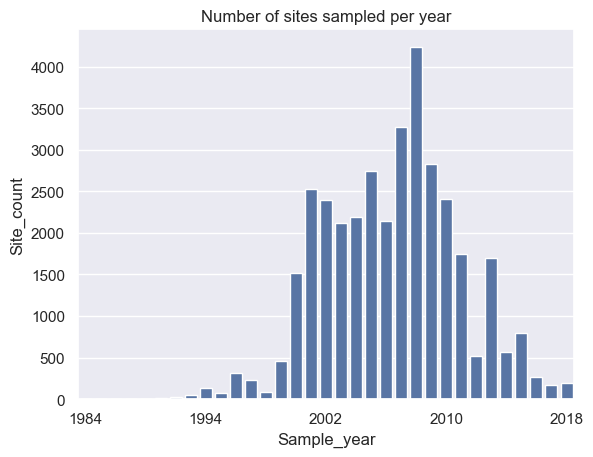

In [28]:
# Plot the results
sns.set_style("dark")
sns.set()
ax = sns.barplot(data=yearly_count, x="Sample_year", y="Site_count")
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.title("Number of sites sampled per year")
plt.show()

## Functions for plotting

In [29]:
def _number_formatter(max_val):
    """Return a formatter function based on the maximum value in the data."""

    def formatter(value, *args):
        if max_val <= 10:
            return f"{value:.1f}"
        else:
            return f"{value:,.0f}"

    return formatter

In [30]:
def plot_frequencies(
    df: pl.DataFrame,
    group_col: str,
    count_type: str,
    title: str,
    sort_descending: bool = True,
    flip_axes: bool = False,
    figsize: tuple = (10, 6),
    style: str = "dark",
) -> None:
    """
    Plot frequencies of unique values or counts in a specified column, grouped by another column.

    Args:
        df: Dataframe containing the data for plotting.
        group_col: The column name to group by.
        count_type: Specifies whether to count 'measurements' or 'unique_values'.
        title: The title for the plot.
        sort_descending: Defaults is to sort in descending order.
        flip_axes: Whether to flip the x and y axes. Defaults to False.
        figsize: The size of the plot. Defaults to (10, 6).
        style: The seaborn visual style for the plot. Defaults to 'dark'.
    """
    assert count_type in [
        "samples",
        "sites",
        "studies",
    ], "count_type must be either 'samples', 'sites' or 'studies'"

    # Define the aggregation function based on count_type
    if count_type == "samples":
        agg_func = pl.col("SSBS").count()
    elif count_type == "sites":
        agg_func = pl.col("SSBS").n_unique()
    elif count_type == "studies":
        agg_func = pl.col("SS").n_unique()

    # Create new DataFrame from groupby and aggregation
    df_counts = (
        df.group_by(group_col)
        .agg(agg_func.alias("Frequency"))
        .sort(pl.col("Frequency"), descending=sort_descending)
    )

    # Calculate the maximum value in the data and get formatter
    max_val = df_counts.select(pl.col("Frequency").max()).item()
    formatter = _number_formatter(max_val)

    # Set figure style and create figure
    sns.set_style(style)
    sns.set()
    plt.figure(figsize=figsize)

    # Create the barplot with the specified orientation
    if flip_axes:
        ax = sns.barplot(data=df_counts, x="Frequency", y=group_col, linewidth=0)
        plt.xlabel("Frequency")
        plt.ylabel(group_col)
        ax.xaxis.set_major_formatter(FuncFormatter(formatter))
    else:
        ax = sns.barplot(data=df_counts, x=group_col, y="Frequency", linewidth=0)
        plt.xlabel(group_col)
        plt.ylabel("Frequency")
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))

    # Add labels to bars and show the plot
    ax.bar_label(ax.containers[0], fmt=formatter, padding=3)
    plt.title(title, fontsize=14)
    plt.show()

In [31]:
def plot_histogram_with_density(
    df: pl.DataFrame,
    data_col: str,
    title: str,
    xlabel: str,
    bins: int = 50,
    kde: bool = True,
    lower_lim: int = None,
    upper_lim: int = None,
    figsize: tuple = (10, 6),
    style: str = "dark",
) -> None:
    """
    Plots a histogram with a density overlay for the specified column of a DataFrame.

    Args:
        df: Dataframe containing the data for plotting.
        data_col: The name of the column to plot.
        xlabel: The label for the x-axis.
        title: The title for the plot.
        bins: The number of bins to use for the histogram. Defaults to 50.
        kde: Whether to overlay a kernel density estimate. Defaults to True.
        lower_lim: Smallest value to display in the plot. Defaults to None.
        upper_lim: Largest value to display in the plot. Defaults to None.
        figsize: The size of the plot. Defaults to (10, 6).
        style: The seaborn visual style for the plot. Defaults to 'dark'.
    """
    assert data_col in df.columns, "Dataframe must contain data_col"

    # Filter the dataframe for the lower and upper thresholds
    if lower_lim:
        df = df.filter(pl.col(data_col) >= lower_lim)
    if upper_lim:
        df = df.filter(pl.col(data_col) <= upper_lim)

    # Calculate the maximum value in the data and get formatter
    max_val = df.select(pl.col(data_col).max()).item()
    formatter = _number_formatter(max_val)

    # Set figure style and create plot
    sns.set_style(style)
    sns.set()
    plt.figure(figsize=figsize)
    ax = sns.histplot(df.select(data_col), bins=bins, kde=kde, legend=False)

    # Set formatting
    ax.xaxis.set_major_formatter(FuncFormatter(formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    plt.show()

In [32]:
def plot_violin(
    df: pl.DataFrame,
    data_col: str,
    title: str,
    category_col: str = "Predominant_land_use",
    figsize: tuple = (10, 6),
) -> None:
    """
    Creates a violin plot for a numerical column grouped by categories, with a reference line.

    Args:
        df: Polars DataFrame containing the data for plotting.
        data_col: The column containing numerical values to plot.
        category_col: The categorical column for grouping data. Defaults to "Predominant_land_use".
        figsize: Size of the figure (width, height). Defaults to (12, 6).
    """
    # Define category order and reference category for land use
    if category_col == "Predominant_land_use":
        category_order = [
            "Primary vegetation",
            "Mature secondary vegetation",
            "Intermediate secondary vegetation",
            "Young secondary vegetation",
            "Secondary vegetation (indeterminate age)",
            "Plantation forest",
            "Pasture",
            "Cropland",
            "Urban",
            "Cannot decide",
        ]
        reference_category = "Primary vegetation"

    # Calculate the mean value for the reference category
    reference_mean = (
        df.filter(pl.col(category_col) == reference_category)
        .select(pl.col(data_col).mean())
        .item()
    )

    # Create the plot
    plt.figure(figsize=figsize)
    sns.violinplot(
        data=df,  # Directly convert Polars DataFrame to Pandas for Seaborn
        x=category_col,
        y=data_col,
        order=category_order,
        cut=0,
    )

    # Add a reference line for the mean of the reference category
    plt.axhline(
        y=reference_mean,
        color="red",
        linestyle="--",
        linewidth=1,
        label=f"Mean ({reference_category}): {reference_mean:.2f}",
    )

    # Add labels, title, and ticks
    plt.title(title, fontsize=14)
    plt.xlabel(category_col, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

## Diversity metrics

### Measurements per diversity metric and abundance unit type

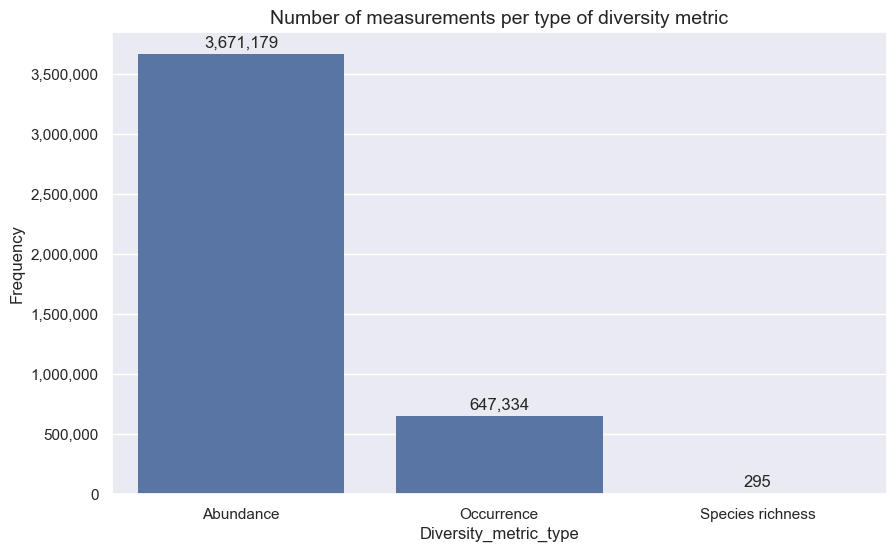

In [33]:
plot_frequencies(
    df_predicts,
    group_col="Diversity_metric_type",
    count_type="samples",
    title="Number of measurements per type of diversity metric",
    sort_descending=True,
    flip_axes=False,
)

### Filtering of data for rest of analysis

Since most biodiversity metrics are abundance-based, we filter the dataframe to only contain abundance measurements.

In [34]:
# Filter dataframe to only include abundance measurements
df_abundance = df_predicts.filter(pl.col("Diversity_metric_type") == "Abundance")

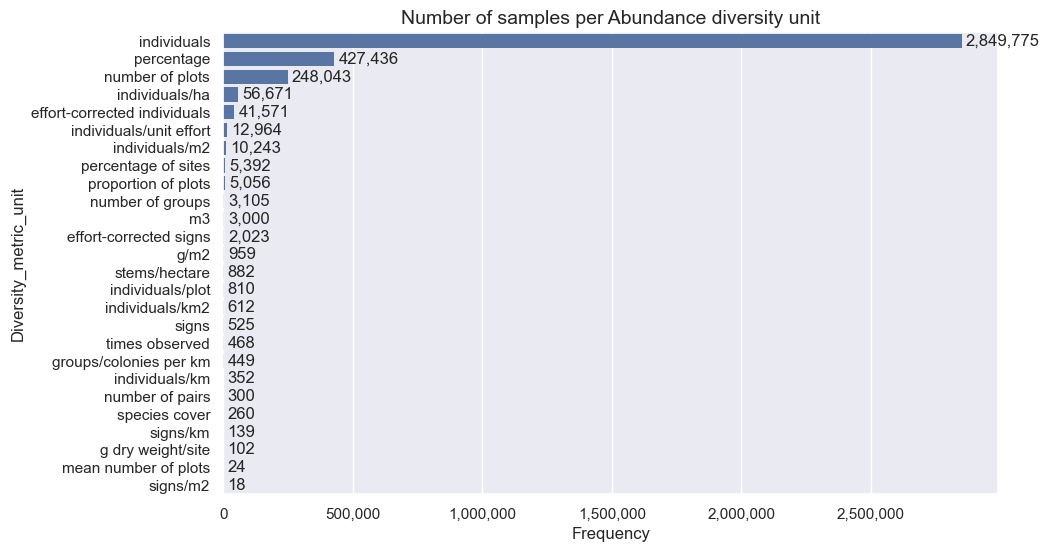

In [36]:
plot_frequencies(
    df_abundance,
    group_col="Diversity_metric_unit",
    count_type="samples",
    title="Number of samples per Abundance diversity unit",
    sort_descending=True,
    flip_axes=True,
)

## Geographic and biogeographic coverage

### Realms and biomes

In [37]:
# List all realms
df_abundance.select(pl.col("Realm")).unique().to_series().to_list()

['Australasia',
 'Palearctic',
 'Afrotropic',
 'Nearctic',
 'Oceania',
 'Indo-Malay',
 'Neotropic']

In [38]:
# List all biomes per realm
# Get unique realms
realms = df_abundance.select("Realm").unique().to_series().to_list()

# Loop through each realm and get unique biomes
for realm in realms:
    biomes = (
        df_abundance.filter(pl.col("Realm") == realm)
        .select("Biome")
        .unique()
        .to_series()
        .to_list()
    )
    print(f"{realm}:\n{biomes}\n")

Afrotropic:
['Montane Grasslands & Shrublands', 'Deserts & Xeric Shrublands', 'Tropical & Subtropical Grasslands, Savannas & Shrublands', 'Mangroves', 'Mediterranean Forests, Woodlands & Scrub', 'Tropical & Subtropical Dry Broadleaf Forests', 'Tropical & Subtropical Moist Broadleaf Forests']

Oceania:
['Tropical & Subtropical Dry Broadleaf Forests', 'Tropical & Subtropical Moist Broadleaf Forests']

Palearctic:
['Temperate Broadleaf & Mixed Forests', 'Temperate Conifer Forests', 'Mediterranean Forests, Woodlands & Scrub', 'Tundra', 'Temperate Grasslands, Savannas & Shrublands', 'Deserts & Xeric Shrublands', 'Boreal Forests/Taiga', 'Montane Grasslands & Shrublands']

Neotropic:
['Flooded Grasslands & Savannas', 'Tropical & Subtropical Dry Broadleaf Forests', 'Temperate Grasslands, Savannas & Shrublands', 'Tropical & Subtropical Coniferous Forests', 'Montane Grasslands & Shrublands', 'Tropical & Subtropical Moist Broadleaf Forests', 'Temperate Broadleaf & Mixed Forests', 'Mangroves', 'De

### Studies and sites per biome

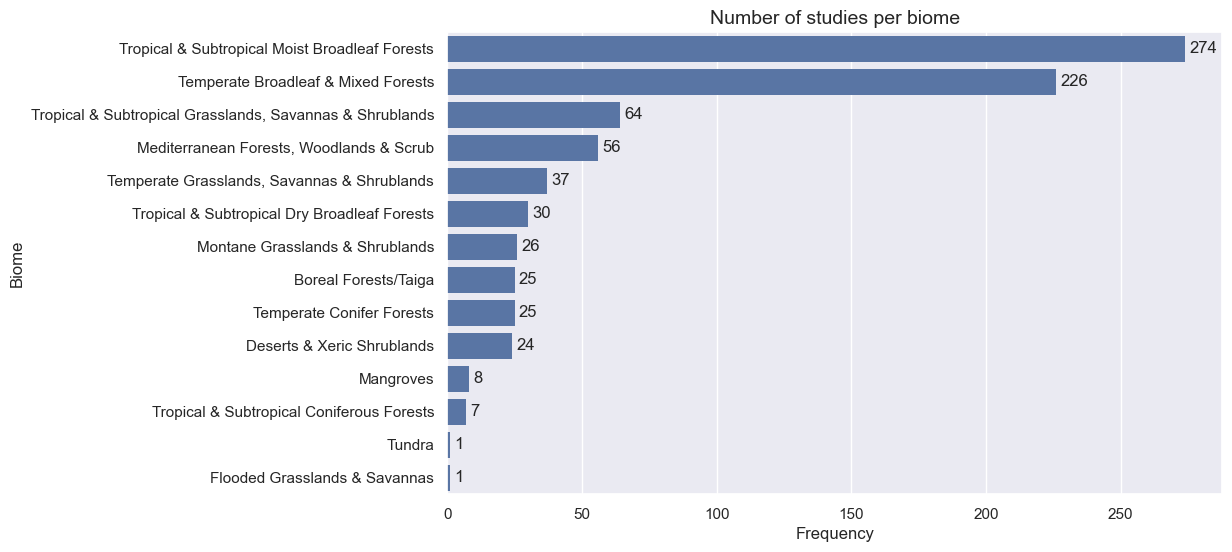

In [39]:
plot_frequencies(
    df_abundance,
    group_col="Biome",
    count_type="studies",
    title="Number of studies per biome",
    sort_descending=True,
    flip_axes=True,
)

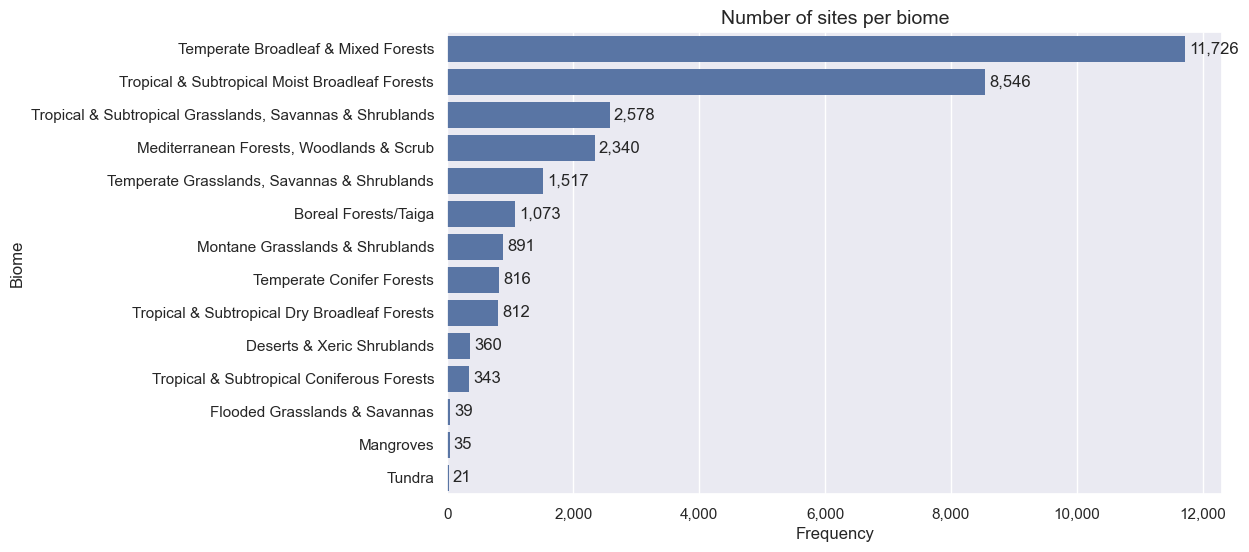

In [40]:
plot_frequencies(
    df_abundance,
    group_col="Biome",
    count_type="sites",
    title="Number of sites per biome",
    sort_descending=True,
    flip_axes=True,
)

### Studies and sites per realm-biome combination

In [41]:
df_abundance = df_abundance.with_columns(
    (pl.col("Realm") + "_" + pl.col("Biome")).alias("Realm_Biome")
)

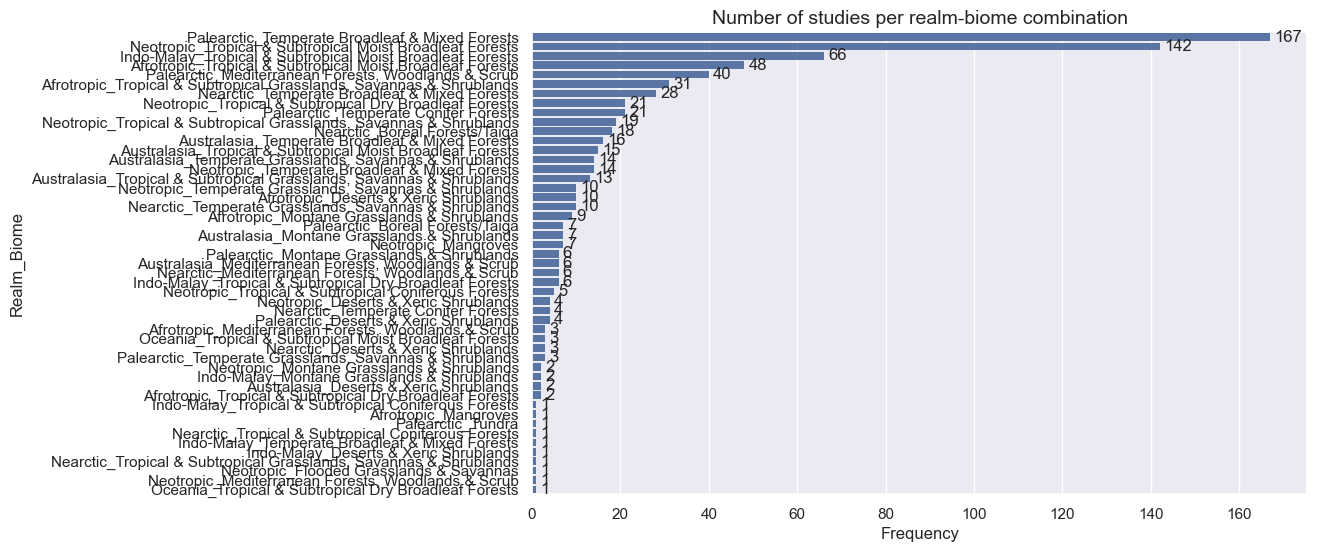

In [43]:
plot_frequencies(
    df_abundance,
    group_col="Realm_Biome",
    count_type="studies",
    title="Number of studies per realm-biome combination",
    sort_descending=True,
    flip_axes=True,
)

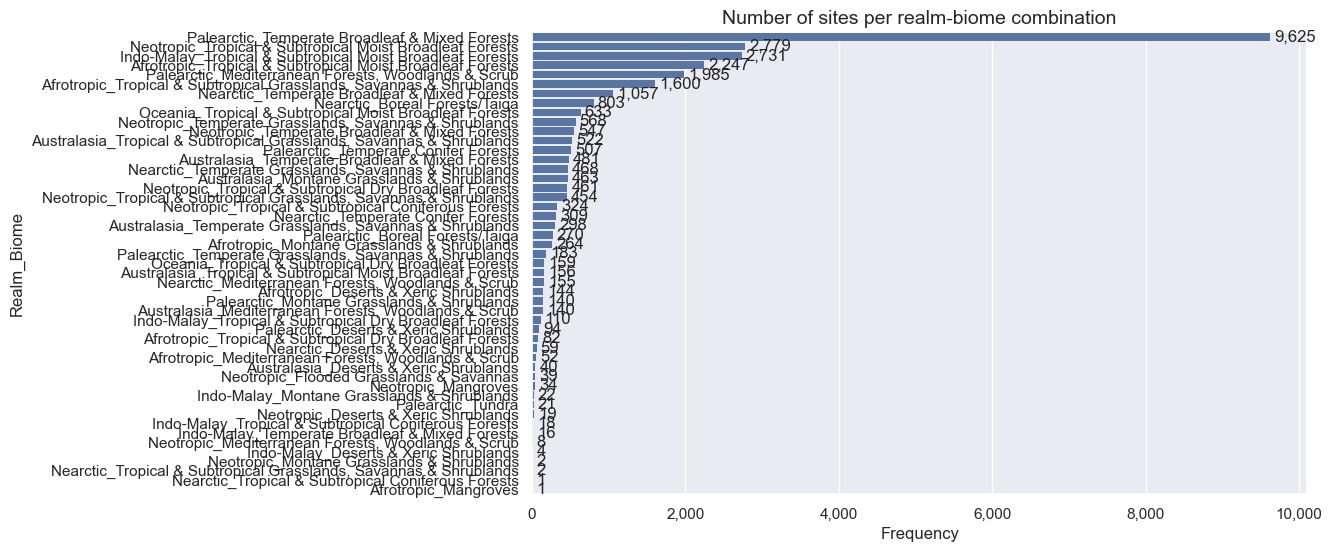

In [44]:
plot_frequencies(
    df_abundance,
    group_col="Realm_Biome",
    count_type="sites",
    title="Number of sites per realm-biome combination",
    sort_descending=True,
    flip_axes=True,
)

### Sites and measurements per UN subregion

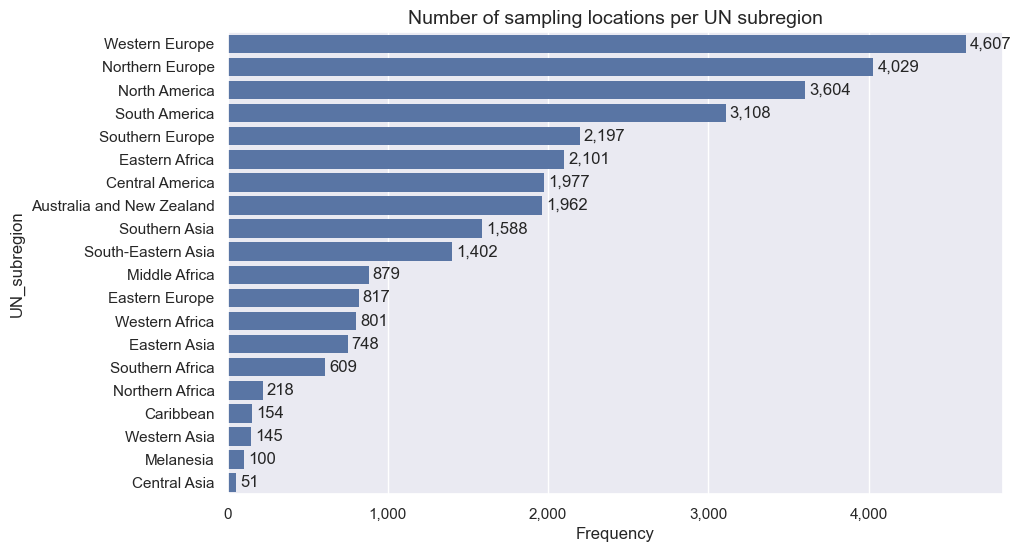

In [58]:
plot_frequencies(
    df_abundance,
    group_col="UN_subregion",
    count_type="unique_values",
    title="Number of sampling locations per UN subregion",
    sort_descending=True,
    flip_axes=True,
)

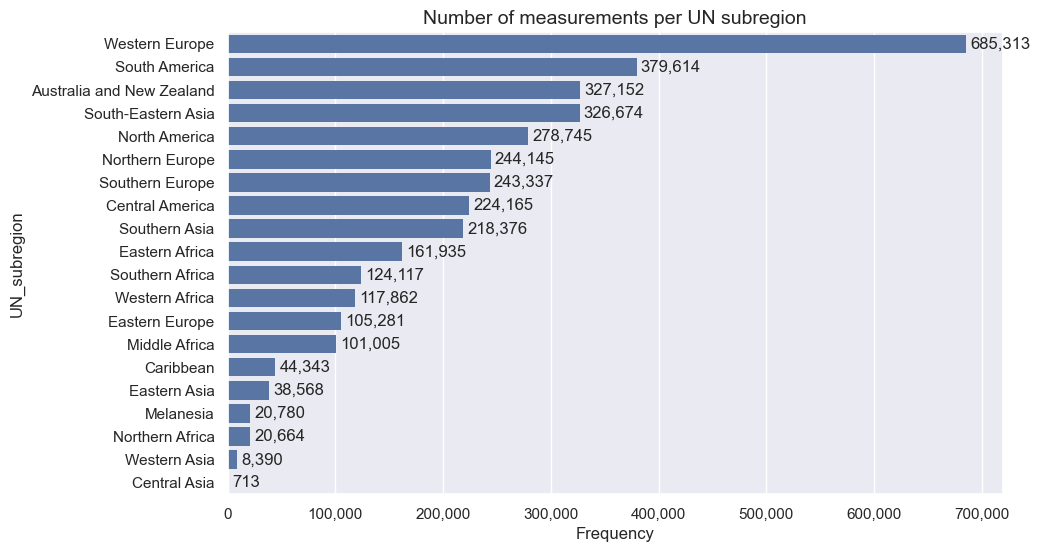

In [59]:
plot_frequencies(
    df_abundance,
    group_col="UN_subregion",
    count_type="measurements",
    title="Number of measurements per UN subregion",
    sort_descending=True,
    flip_axes=True,
)

## Land use coverage

### Sites and measurements per land-use type and intensity 

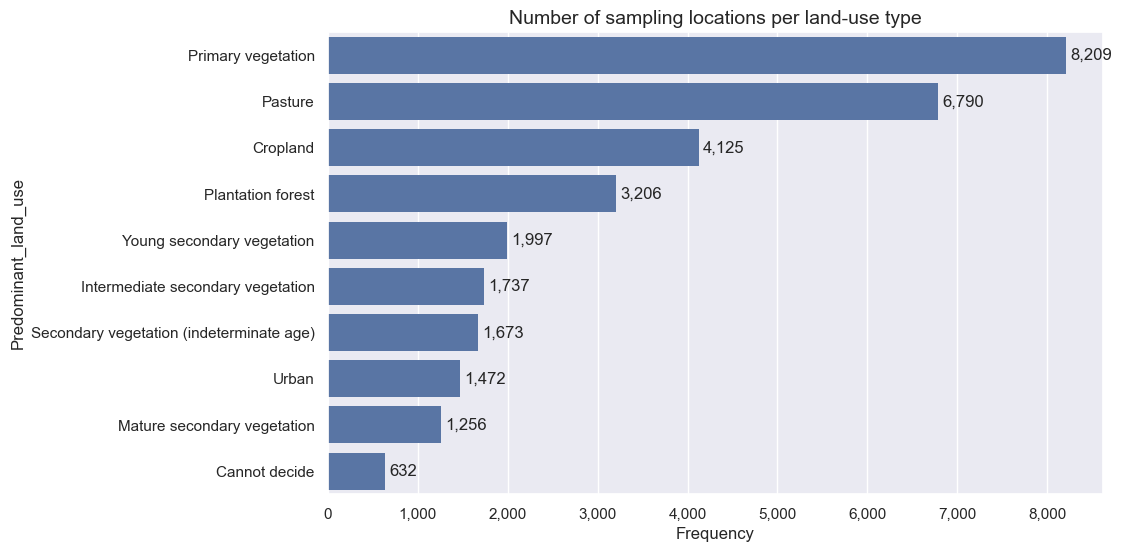

In [60]:
plot_frequencies(
    df_abundance,
    group_col="Predominant_land_use",
    count_type="unique_values",
    title="Number of sampling locations per land-use type",
    sort_descending=True,
    flip_axes=True,
)

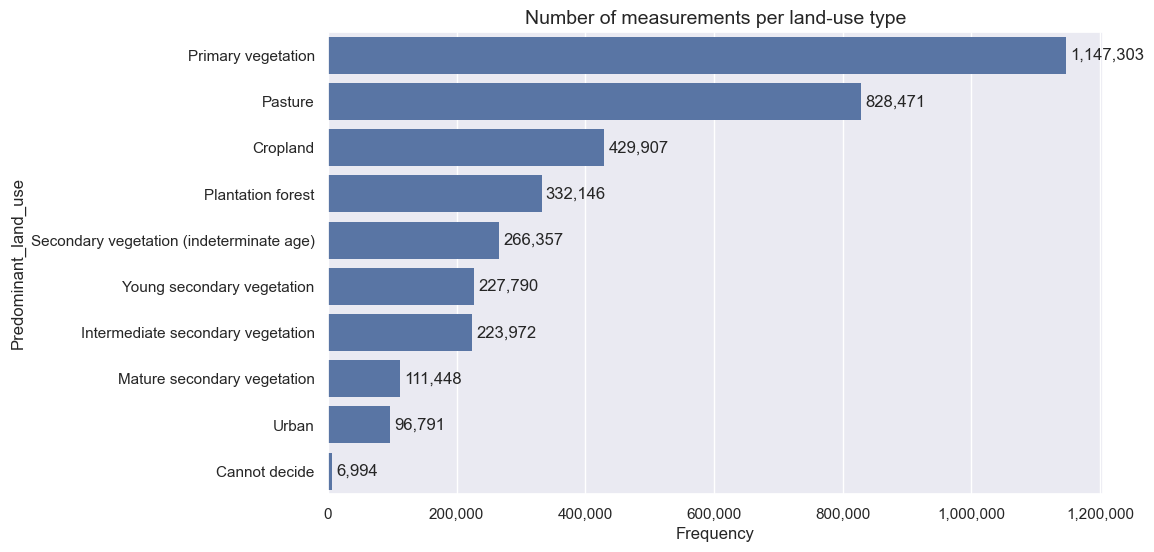

In [61]:
plot_frequencies(
    df_abundance,
    group_col="Predominant_land_use",
    count_type="measurements",
    title="Number of measurements per land-use type",
    sort_descending=True,
    flip_axes=True,
)

In [62]:
# Create land use type x intensity combinations
df_abundance = df_abundance.with_columns(
    (pl.col("Predominant_land_use") + " x " + pl.col("Use_intensity")).alias(
        "Land_use_type_intensity"
    )
)

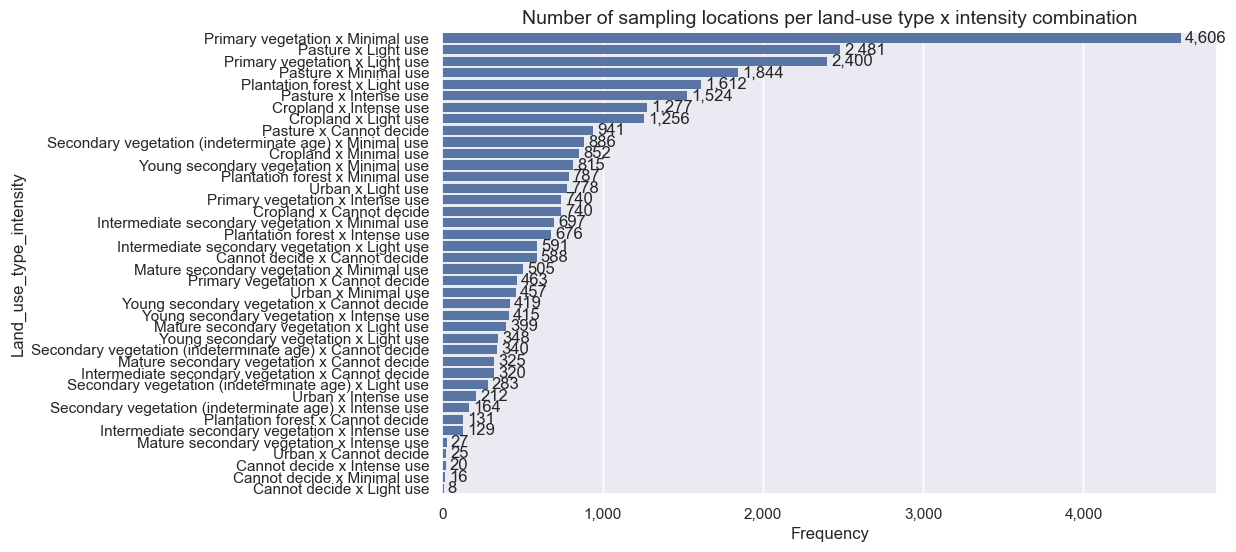

In [63]:
plot_frequencies(
    df_abundance,
    group_col="Land_use_type_intensity",
    count_type="unique_values",
    title="Number of sampling locations per land-use type x intensity combination",
    sort_descending=True,
    flip_axes=True,
)

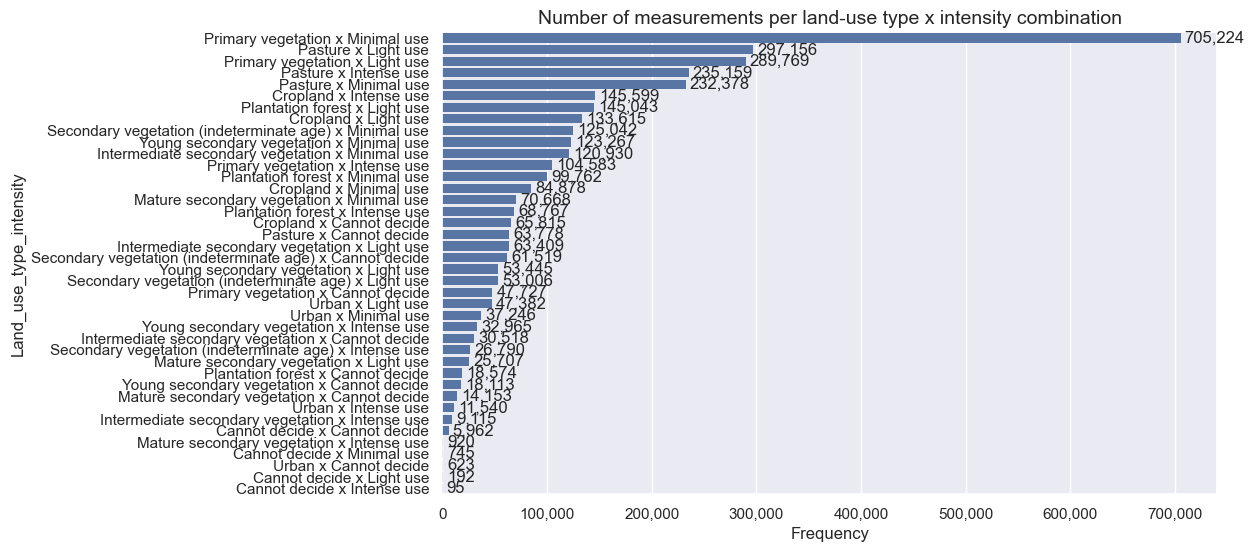

In [64]:
plot_frequencies(
    df_abundance,
    group_col="Land_use_type_intensity",
    count_type="measurements",
    title="Number of measurements per land-use type x intensity combination",
    sort_descending=True,
    flip_axes=True,
)

## Taxonomic coverage

### Sampling locations per Kingdom 

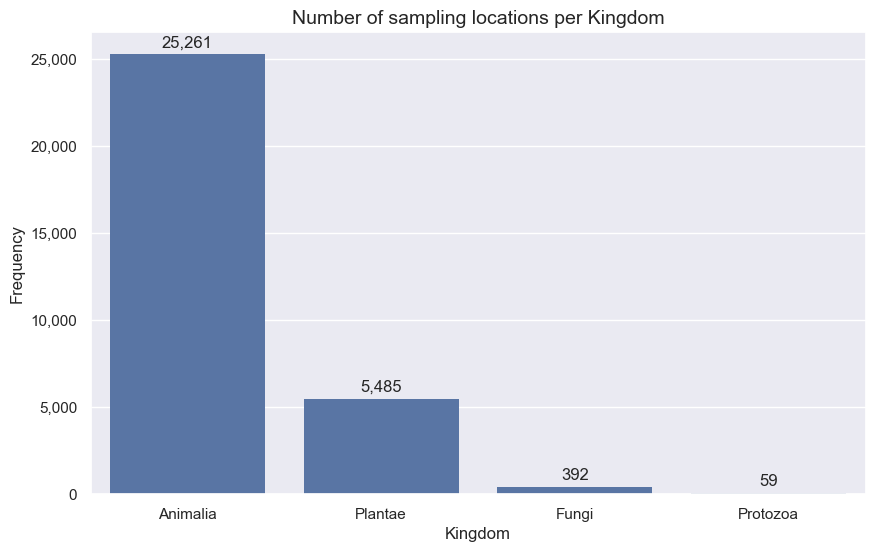

In [65]:
plot_frequencies(
    df_abundance,
    group_col="Kingdom",
    count_type="unique_values",
    title="Number of sampling locations per Kingdom",
    sort_descending=True,
    flip_axes=False,
)

### Sampling locations per Phylum

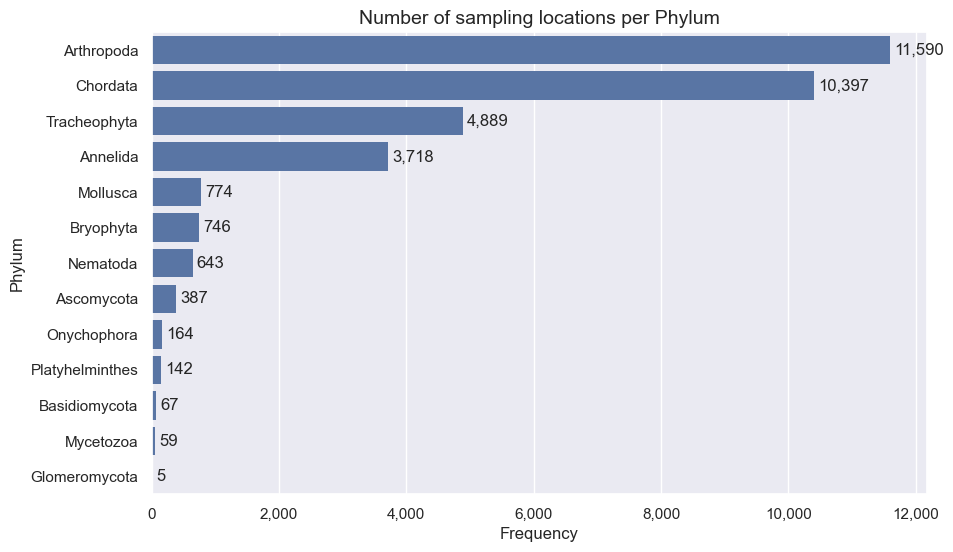

In [66]:
plot_frequencies(
    df_abundance,
    group_col="Phylum",
    count_type="unique_values",
    title="Number of sampling locations per Phylum",
    sort_descending=True,
    flip_axes=True,
)

### Sampling locations per Class

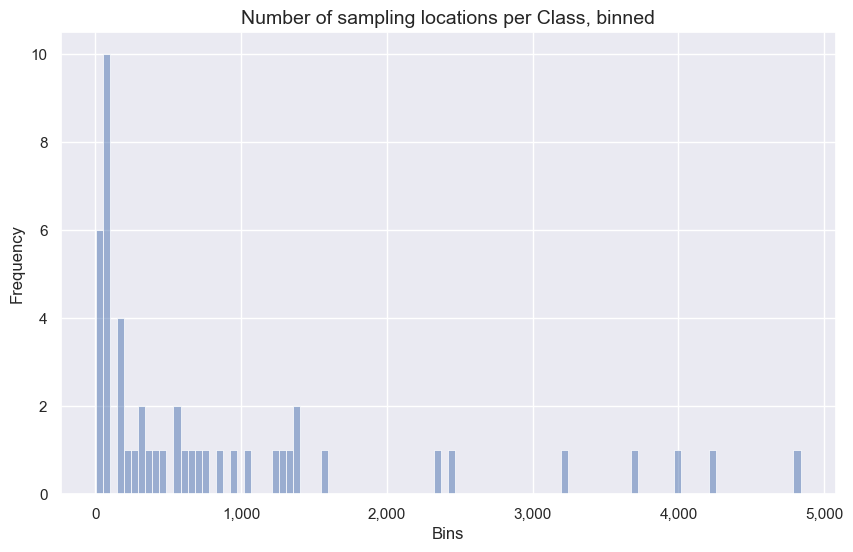

In [67]:
df_class_obs = df_abundance.group_by("Class").agg(
    pl.col("SSBS").n_unique().alias("Class_sites")
)

plot_histogram_with_density(
    df_class_obs,
    data_col="Class_sites",
    title="Number of sampling locations per Class, binned",
    xlabel="Bins",
    bins=100,
    kde=False,
    lower_lim=None,
    upper_lim=5000,  # Note the limmits here
)

### Measurements per Order

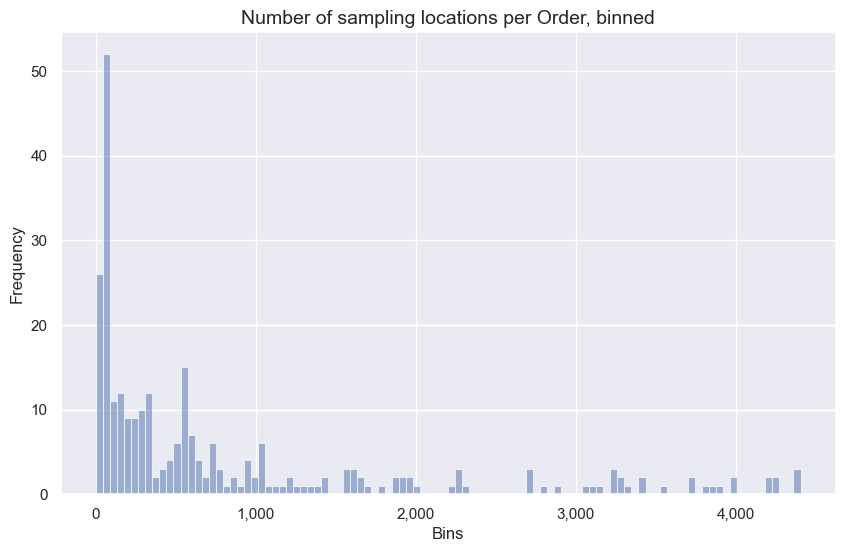

In [68]:
df_order_obs = df_abundance.group_by("Order").agg(
    pl.col("SSBS").n_unique().alias("Order_sites")
)

plot_histogram_with_density(
    df_order_obs,
    data_col="Order_sites",
    title="Number of sampling locations per Order, binned",
    xlabel="Bins",
    bins=100,
    kde=False,
    lower_lim=None,
    upper_lim=5000,  # Note the limmits here
)

### Measurements per Family

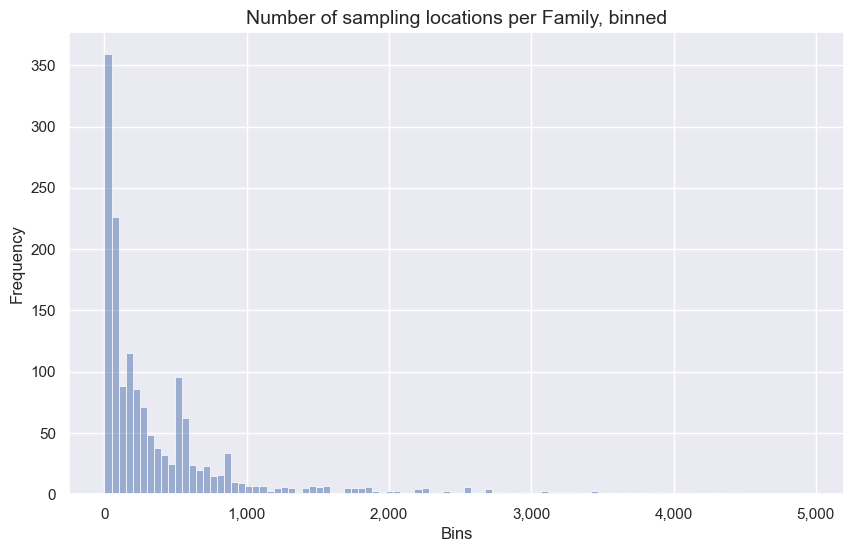

In [69]:
df_family_obs = df_abundance.group_by("Family").agg(
    pl.col("SSBS").n_unique().alias("Family_sites")
)

plot_histogram_with_density(
    df_family_obs,
    data_col="Family_sites",
    title="Number of sampling locations per Family, binned",
    xlabel="Bins",
    bins=100,
    kde=False,
    lower_lim=None,
    upper_lim=5000,  # Note the limmits here
)

## Combinations of biogeography and taxonomy

### Biomes and kingdoms

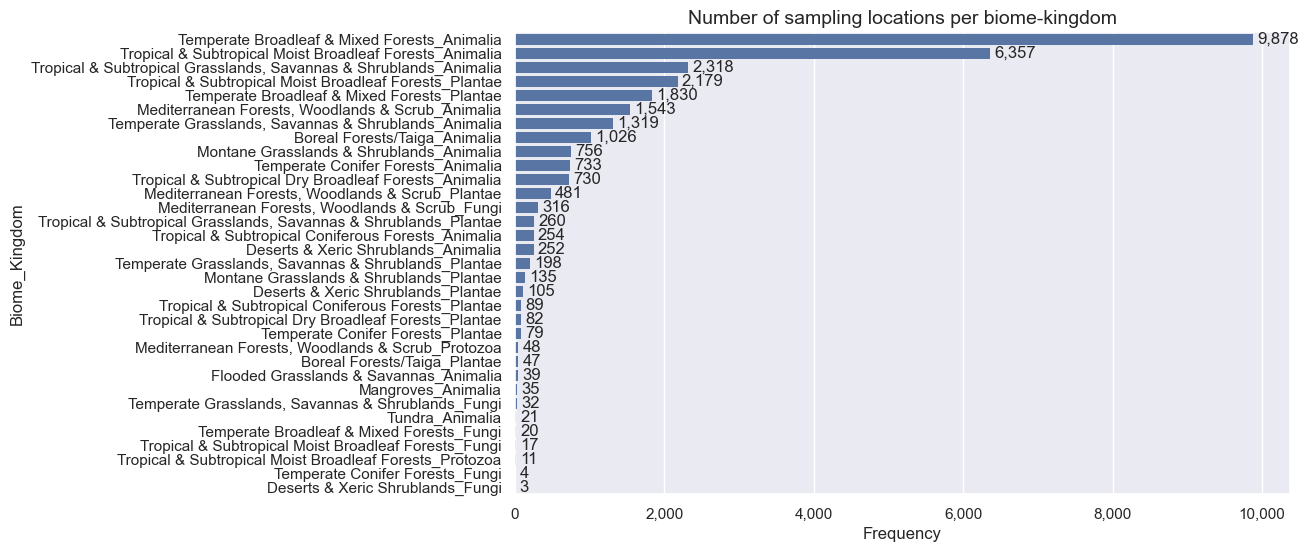

In [70]:
# Create new grouping column
df_abundance = df_abundance.with_columns(
    (pl.col("Biome") + "_" + pl.col("Kingdom")).alias("Biome_Kingdom")
)

plot_frequencies(
    df_abundance,
    group_col="Biome_Kingdom",
    count_type="unique_values",
    title="Number of sampling locations per biome-kingdom",
    sort_descending=True,
    flip_axes=True,
)

### Biomes and phyla

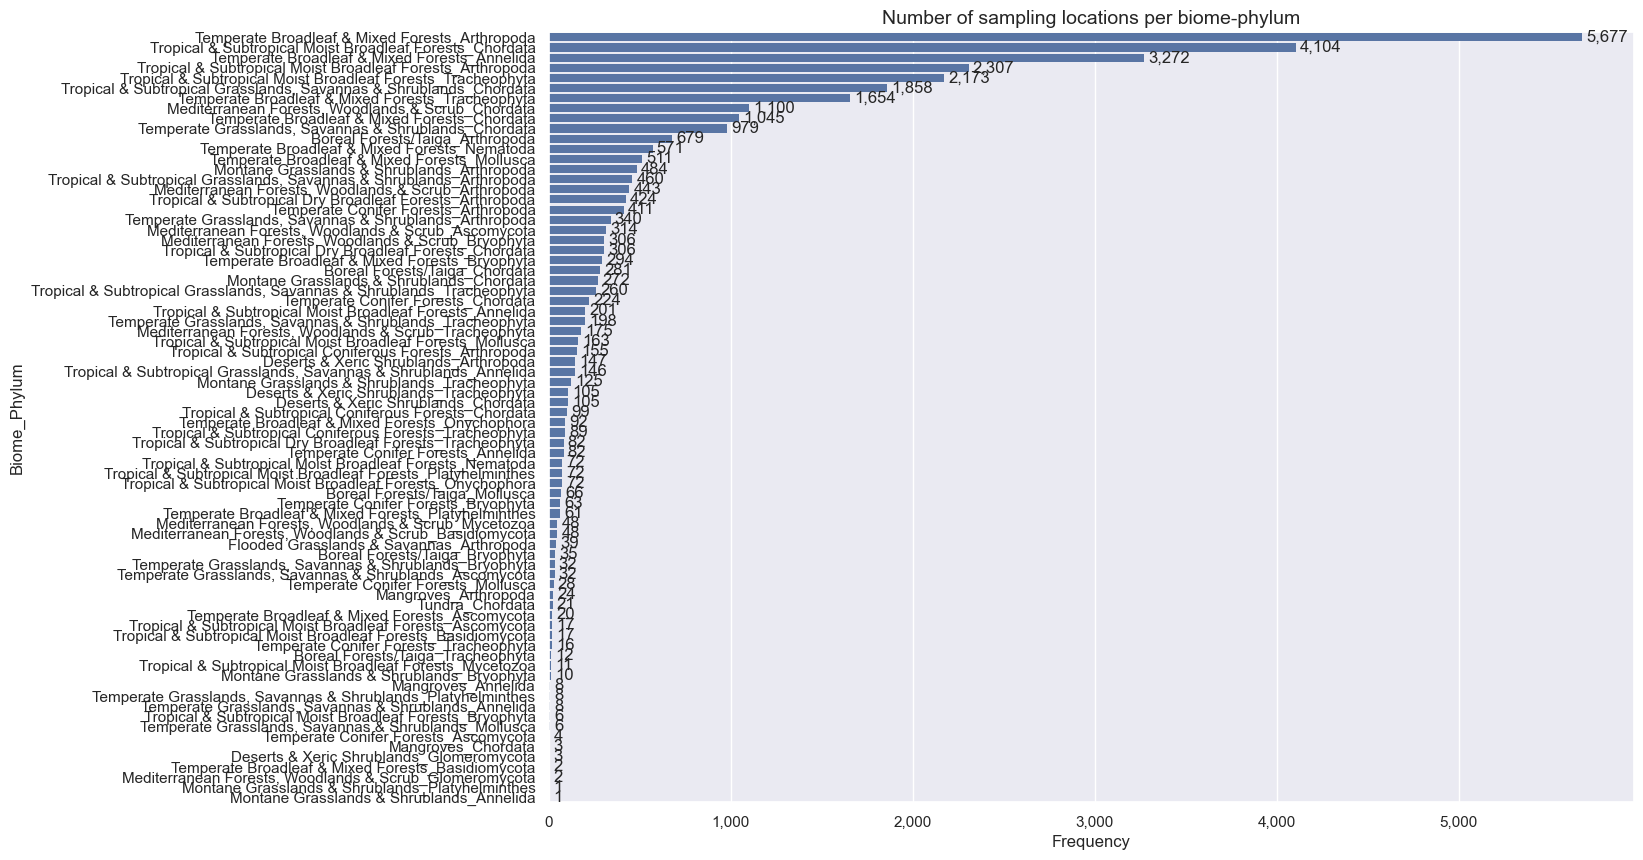

In [71]:
# Create new grouping column
df_abundance = df_abundance.with_columns(
    (pl.col("Biome") + "_" + pl.col("Phylum")).alias("Biome_Phylum")
)

plot_frequencies(
    df_abundance,
    group_col="Biome_Phylum",
    count_type="unique_values",
    title="Number of sampling locations per biome-phylum",
    sort_descending=True,
    flip_axes=True,
    figsize=(14, 10),
)

## Studies and sites for potential hierarchical structures

### Biome_Realm

In [47]:
# Create new grouping column
df_abundance = df_abundance.with_columns(
    pl.concat_str([pl.col("Biome"), pl.col("Realm")], separator="_").alias(
        "Biome_Realm"
    )
)

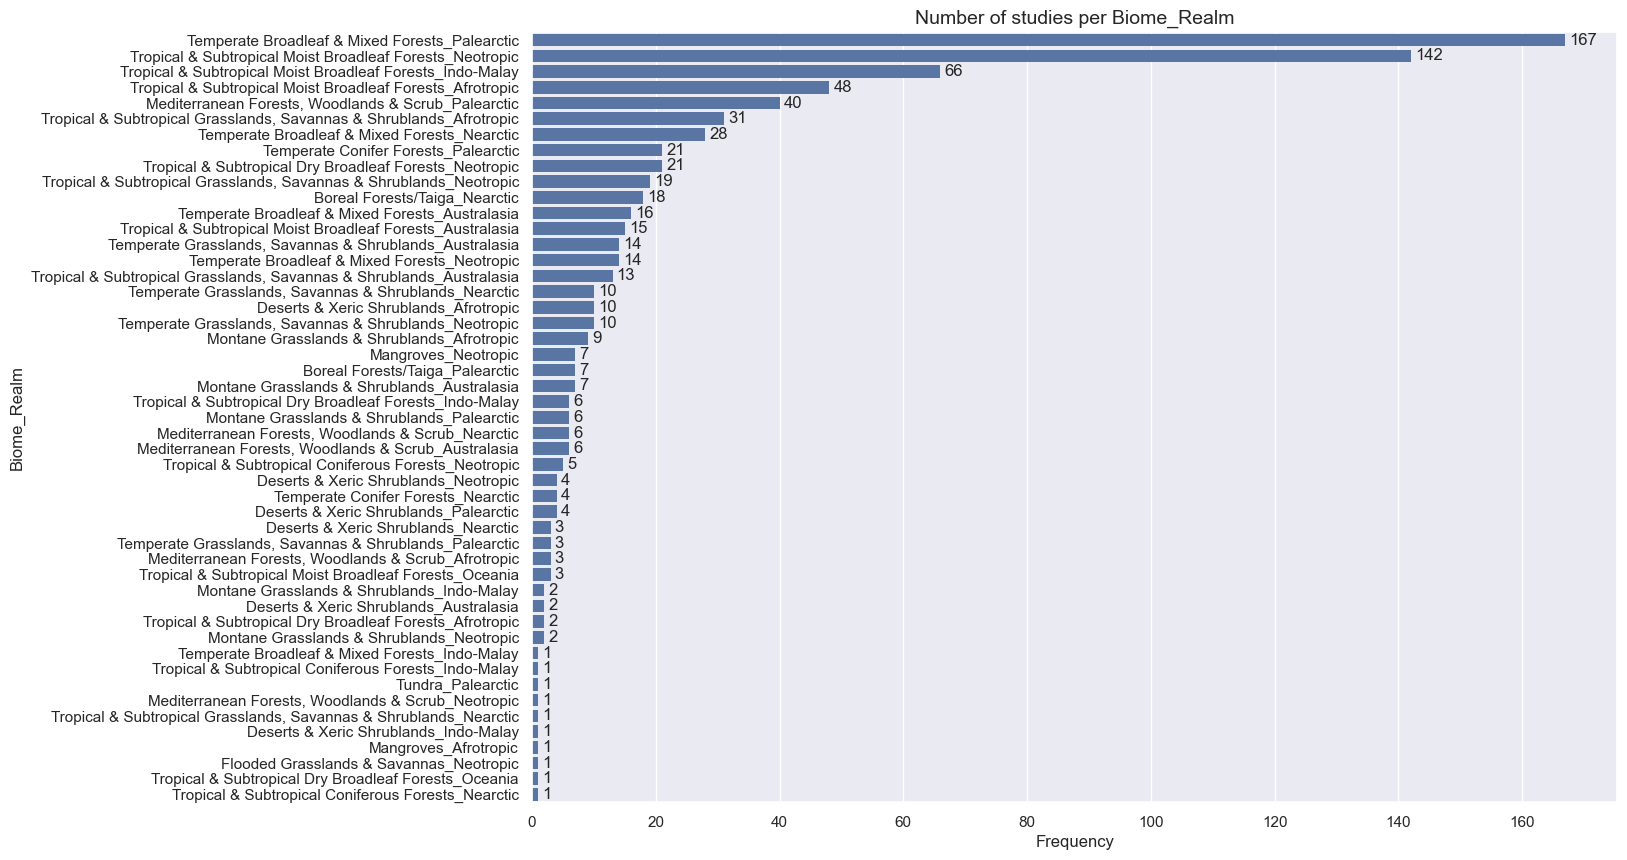

In [48]:
plot_frequencies(
    df_abundance,
    group_col="Biome_Realm",
    count_type="studies",
    title="Number of studies per Biome_Realm",
    sort_descending=True,
    flip_axes=True,
    figsize=(14, 10),
)

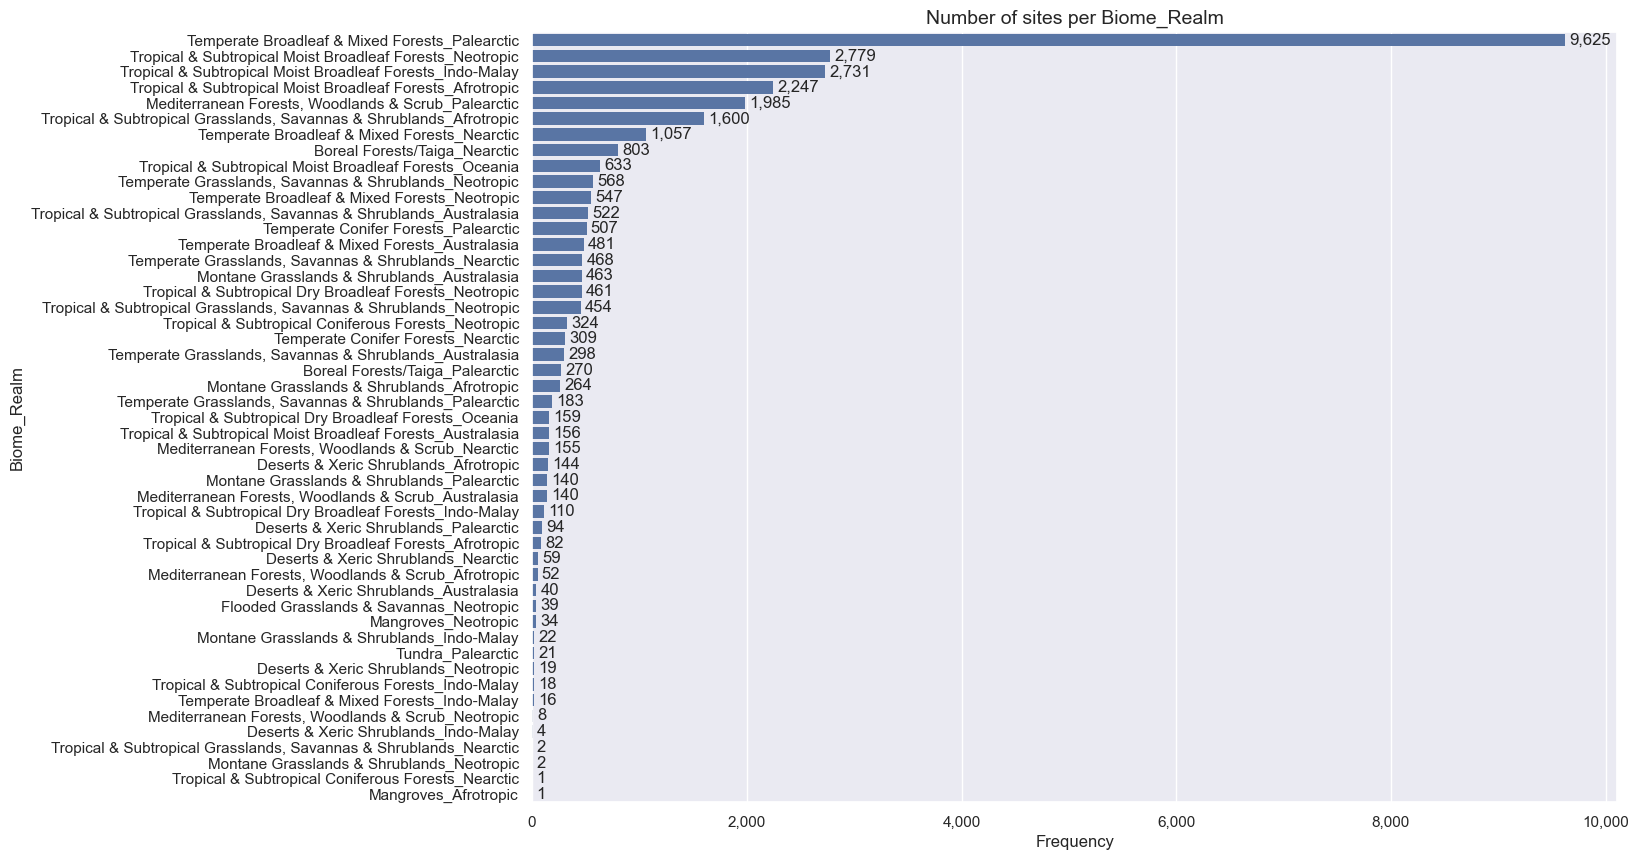

In [49]:
plot_frequencies(
    df_abundance,
    group_col="Biome_Realm",
    count_type="sites",
    title="Number of sites per Biome_Realm",
    sort_descending=True,
    flip_axes=True,
    figsize=(14, 10),
)

### Biome_Realm_Ecoregion

In [50]:
df_abundance = df_abundance.with_columns(
    pl.concat_str(
        [pl.col("Biome"), pl.col("Realm"), pl.col("Ecoregion")], separator="_"
    ).alias("Biome_Realm_Ecoregion")
)

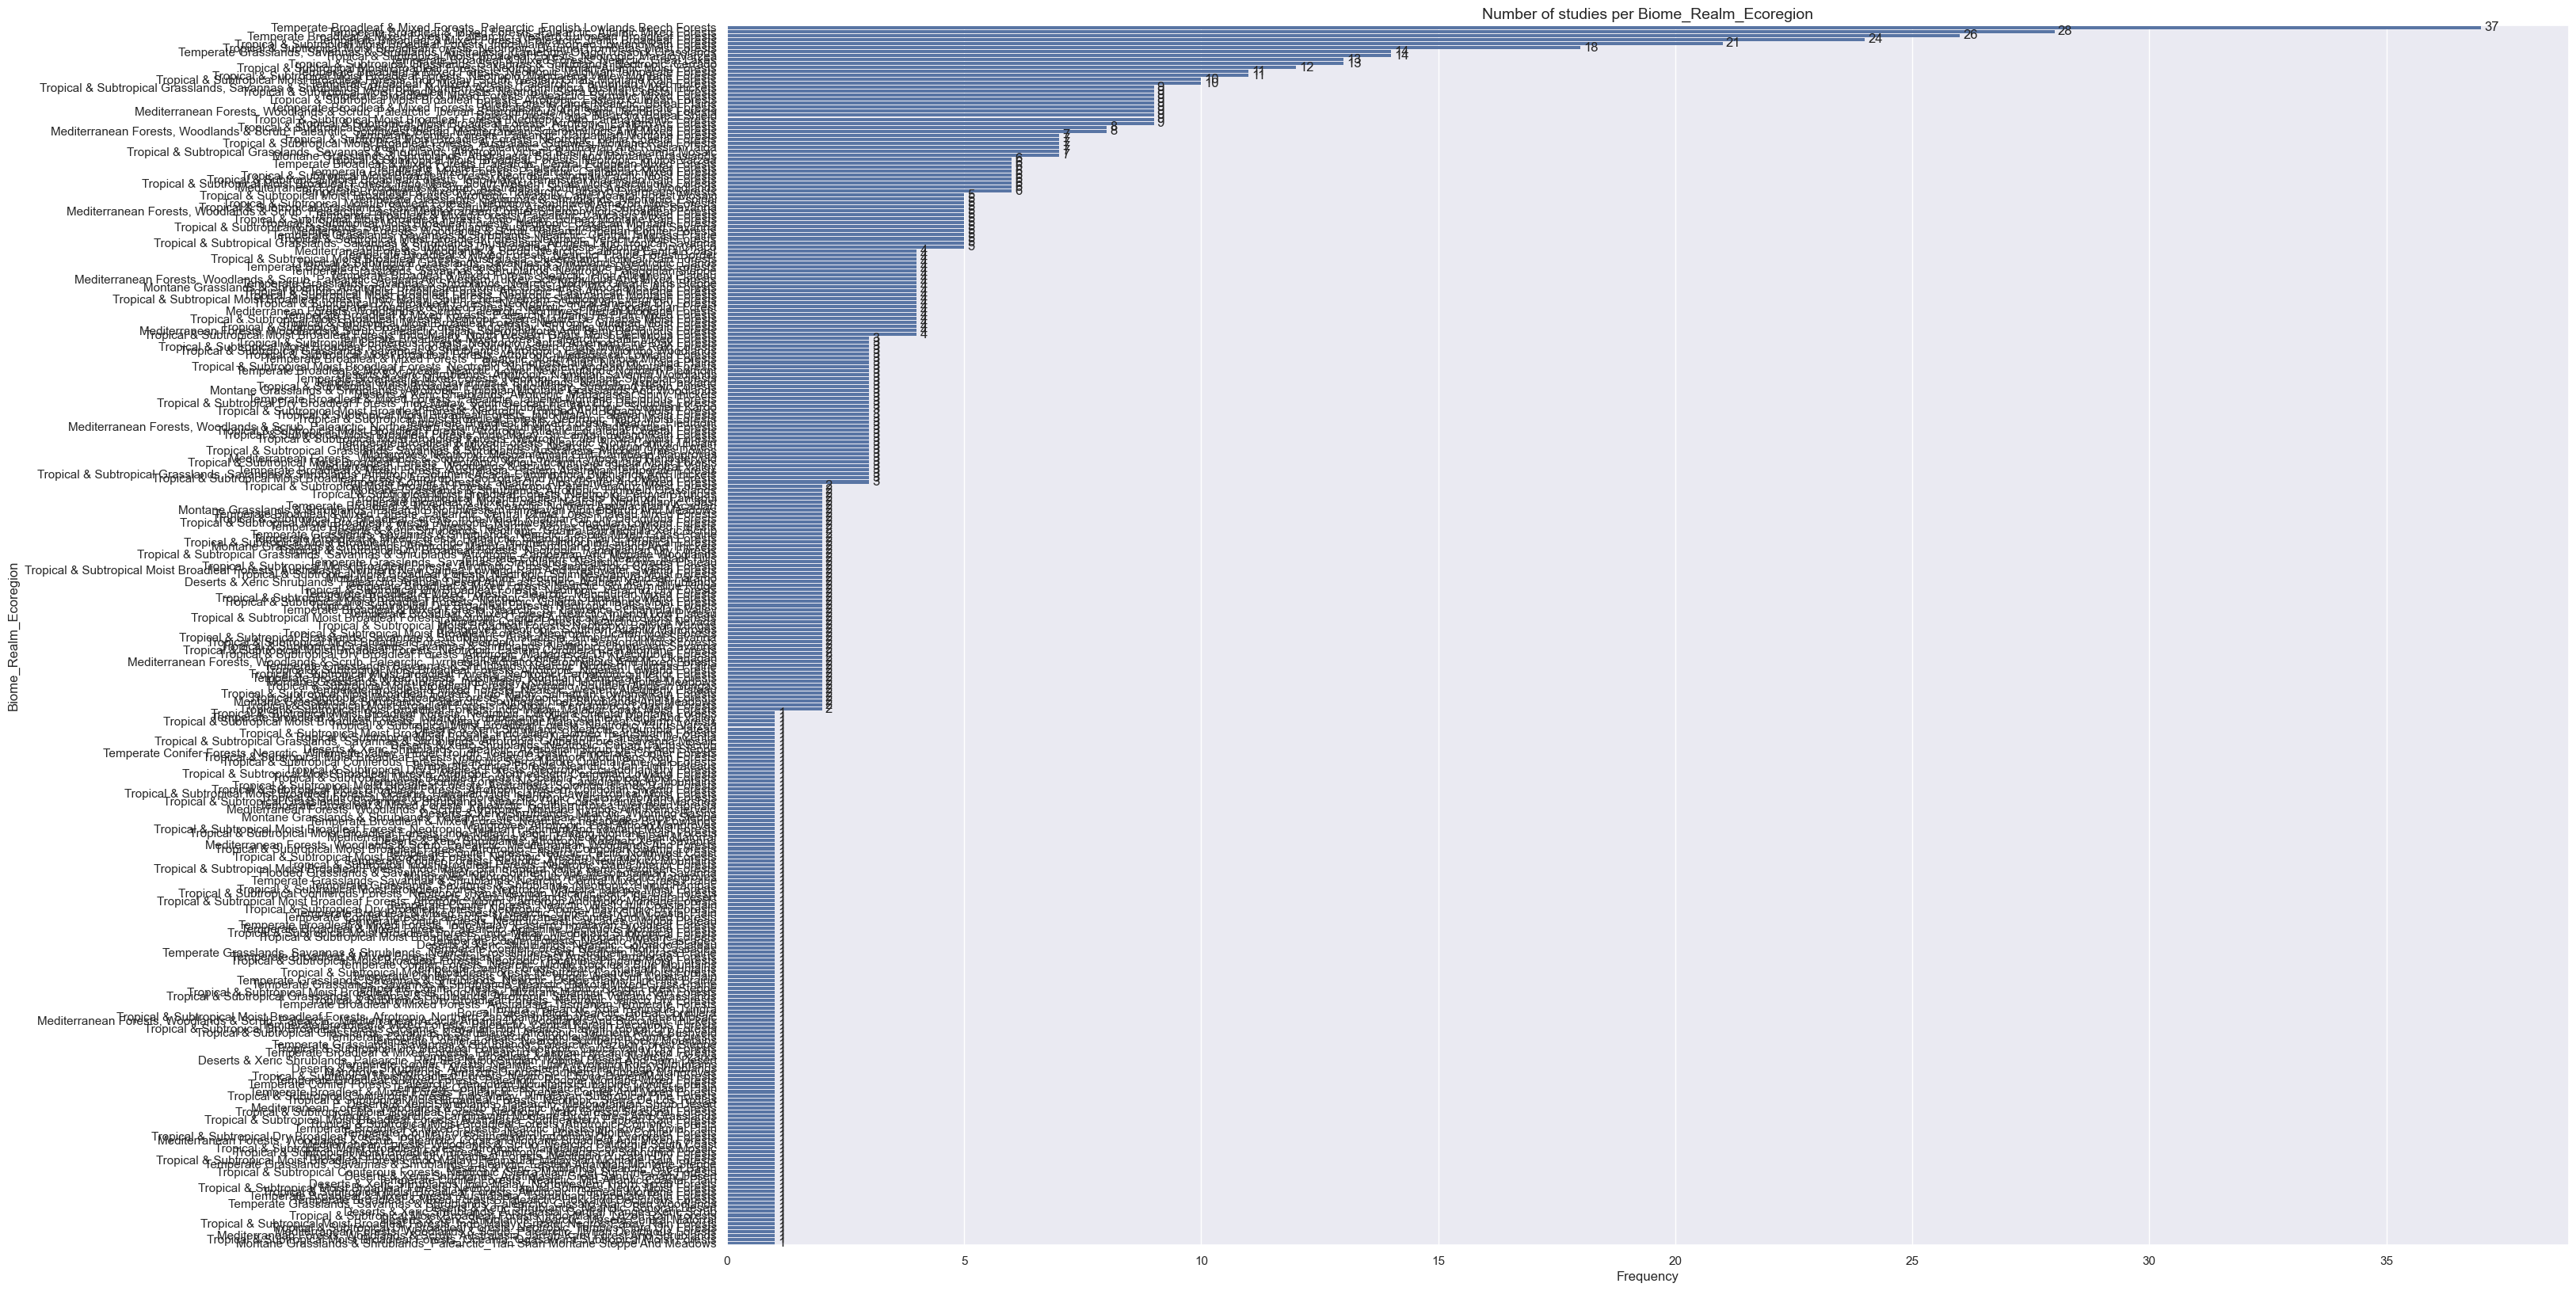

In [53]:
plot_frequencies(
    df_abundance,
    group_col="Biome_Realm_Ecoregion",
    count_type="studies",
    title="Number of studies per Biome_Realm_Ecoregion",
    sort_descending=True,
    flip_axes=True,
    figsize=(30, 20),
)

### Biome_Realm_Kingdom

In [54]:
df_abundance = df_abundance.with_columns(
    pl.concat_str(
        [pl.col("Biome"), pl.col("Realm"), pl.col("Kingdom")], separator="_"
    ).alias("Biome_Realm_Kingdom")
)

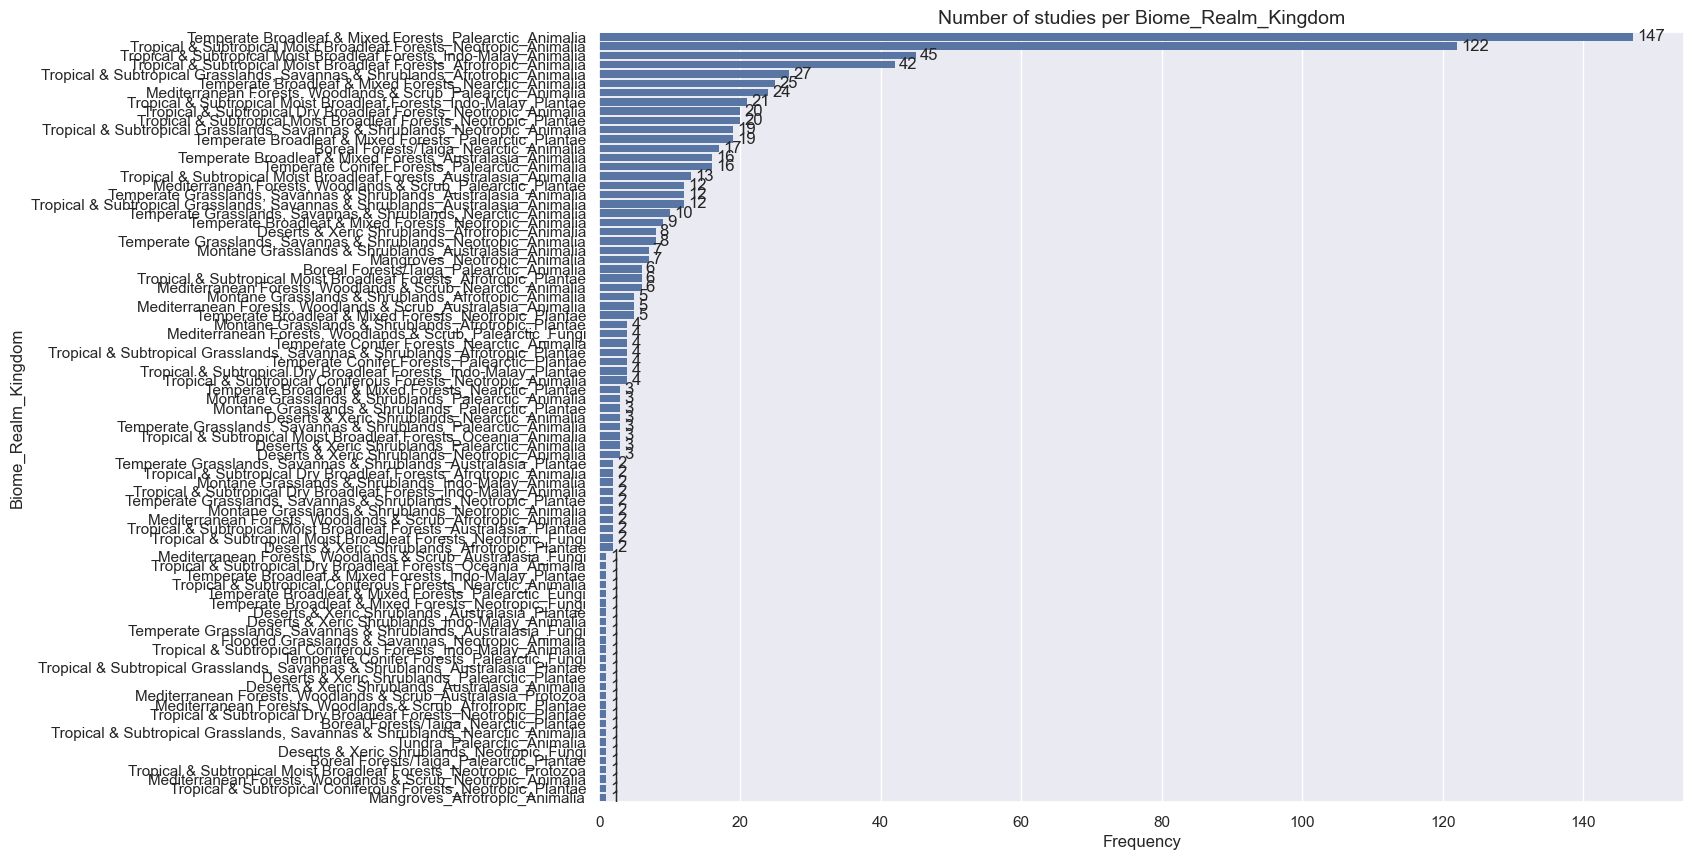

In [55]:
plot_frequencies(
    df_abundance,
    group_col="Biome_Realm_Kingdom",
    count_type="studies",
    title="Number of studies per Biome_Realm_Kingdom",
    sort_descending=True,
    flip_axes=True,
    figsize=(14, 10),
)

## Alpha diversity metrics

## Species richness

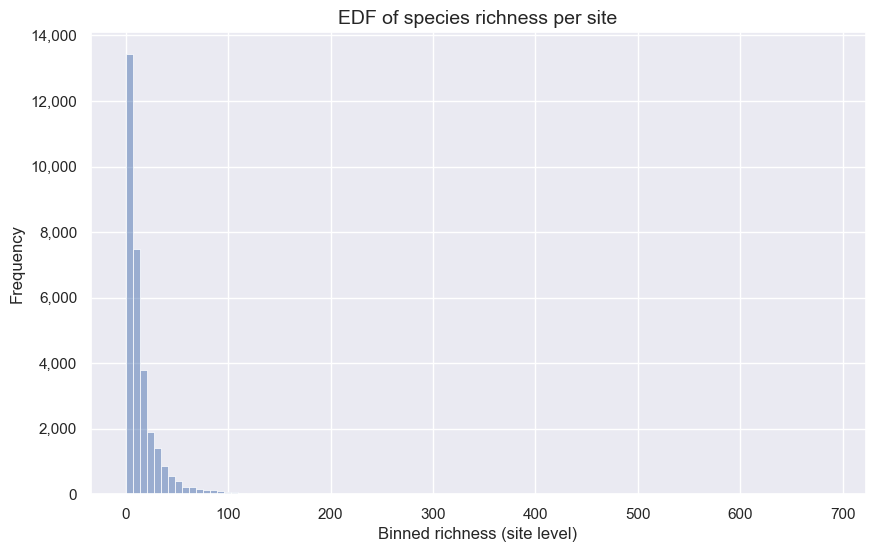

In [72]:
# Create species richness column
df_abundance = df_abundance.with_columns(
    pl.when(pl.col("Effort_corrected_measurement") == 0)
    .then(0)
    .otherwise(1)
    .alias("Species_richness")
)

# Calculate total richness per site
df_richness_per_site = df_abundance.group_by(["SS", "SSBS"]).agg(
    pl.col("Species_richness").sum().alias("Tot_richness")
)

plot_histogram_with_density(
    df_richness_per_site,
    data_col="Tot_richness",
    title="EDF of species richness per site",
    xlabel="Binned richness (site level)",
    bins=100,
    kde=False,
)

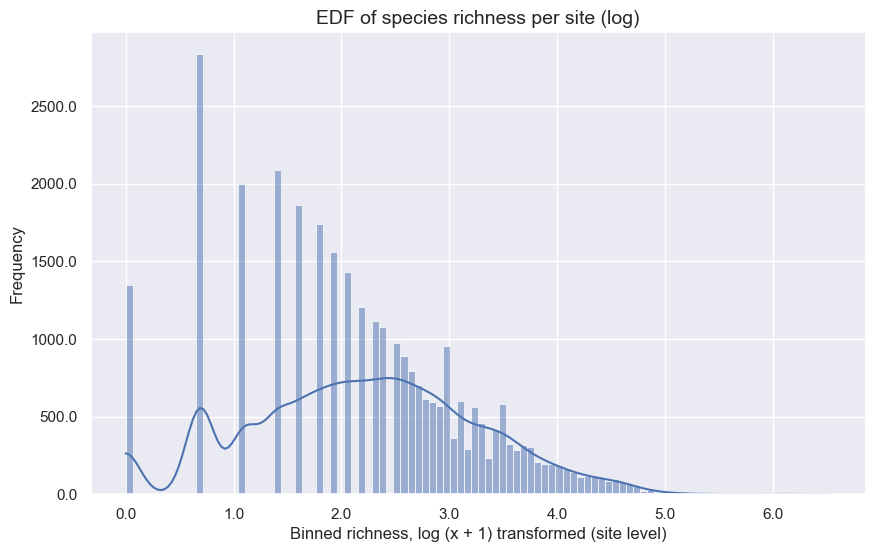

In [73]:
# Perform log(x + 1) transformation of richness numbers
df_richness_per_site_log = df_richness_per_site.with_columns(
    (pl.col("Tot_richness").map_elements(lambda x: np.log(x + 1))).alias(
        "Tot_richness_log"
    )
)

plot_histogram_with_density(
    df_richness_per_site_log,
    data_col="Tot_richness_log",
    title="EDF of species richness per site (log)",
    xlabel="Binned richness, log (x + 1) transformed (site level)",
    bins=100,
    kde=True,
)

### Inter-study standard deviation (between sites)

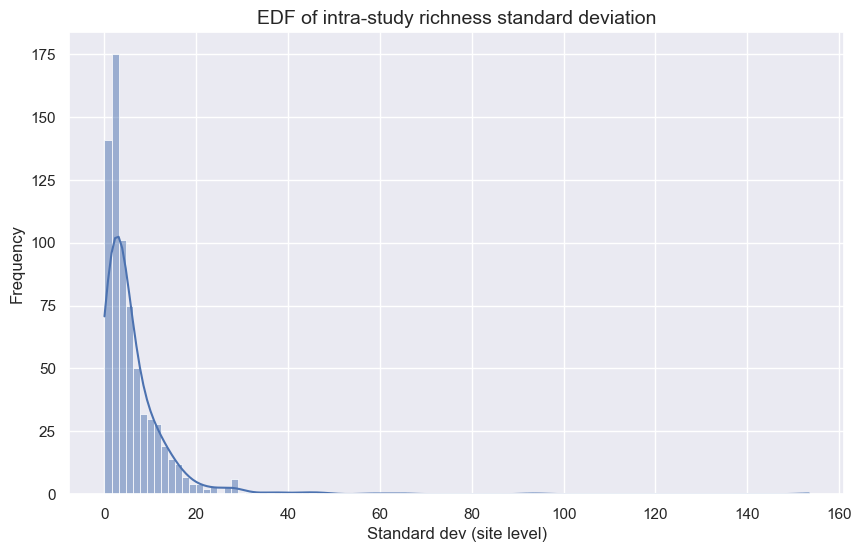

In [74]:
df_richness_std = df_richness_per_site.group_by("SS").agg(
    pl.std("Tot_richness").alias("Richness_std")
)

plot_histogram_with_density(
    df_richness_std,
    data_col="Richness_std",
    title="EDF of intra-study richness standard deviation",
    xlabel="Standard dev (site level)",
    bins=100,
    kde=True,
)

## Species abundance

We use effort corrected measurement data, to get as close as possible to true abundance with the data we have. Dataframe is filtered to only include abundance given as count of individuals. This will make the data easier to analyze

In [75]:
# Filter data
df_abund_ind = df_abundance.filter(pl.col("Diversity_metric_unit") == "individuals")

# Check some summary statistics of the data
df_abund_ind_stats = df_abund_ind.select(
    [
        pl.col("Effort_corrected_measurement").mean().alias("mean"),
        pl.col("Effort_corrected_measurement").median().alias("median"),
        pl.col("Effort_corrected_measurement").min().alias("min"),
        pl.col("Effort_corrected_measurement").max().alias("max"),
        pl.col("Effort_corrected_measurement").std().alias("std"),
    ]
)

# Print each statistic in the desired format
for stat, value in zip(df_abund_ind_stats.columns, df_abund_ind_stats.row(0)):
    print(f"{stat:<10} {value:.3f}")

mean       23.286
median     0.000
min        0.000
max        394656.000
std        575.713


In [76]:
# Do the same analysis, but averaged across sites
df_agg_stats = df_abund_ind.group_by("SSBS").agg(
    [
        pl.mean("Effort_corrected_measurement").alias("mean"),
        pl.median("Effort_corrected_measurement").alias("median"),
        pl.min("Effort_corrected_measurement").alias("min"),
        pl.max("Effort_corrected_measurement").alias("max"),
        pl.std("Effort_corrected_measurement").alias("std"),
    ]
)

# Calculate the mean of each statistic across all sites, excluding "SSBS"
avg_stats = df_agg_stats.select(pl.exclude("SSBS")).mean()

for stat, value in zip(avg_stats.columns, avg_stats.row(0)):
    print(f"{stat:<10} {value:.3f}")

mean       17.585
median     1.520
min        1.256
max        842.852
std        85.708


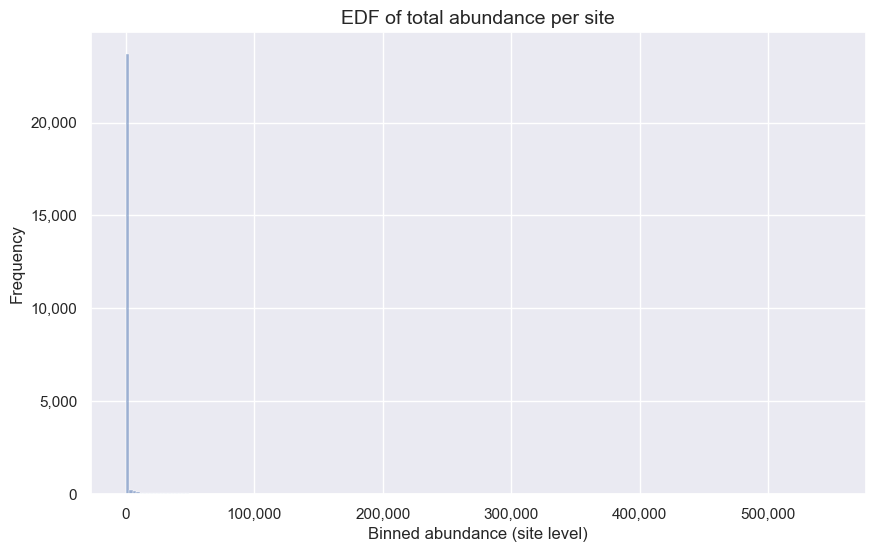

In [77]:
# Calculate total abundance for each site
df_ind_count_per_site = df_abund_ind.group_by(["SS", "SSBS"]).agg(
    pl.col("Effort_corrected_measurement").sum().alias("Tot_abundance")
)

plot_histogram_with_density(
    df_ind_count_per_site,
    data_col="Tot_abundance",
    title="EDF of total abundance per site",
    xlabel="Binned abundance (site level)",
    bins=200,
    kde=False,
)

### Log transformed count of individuals

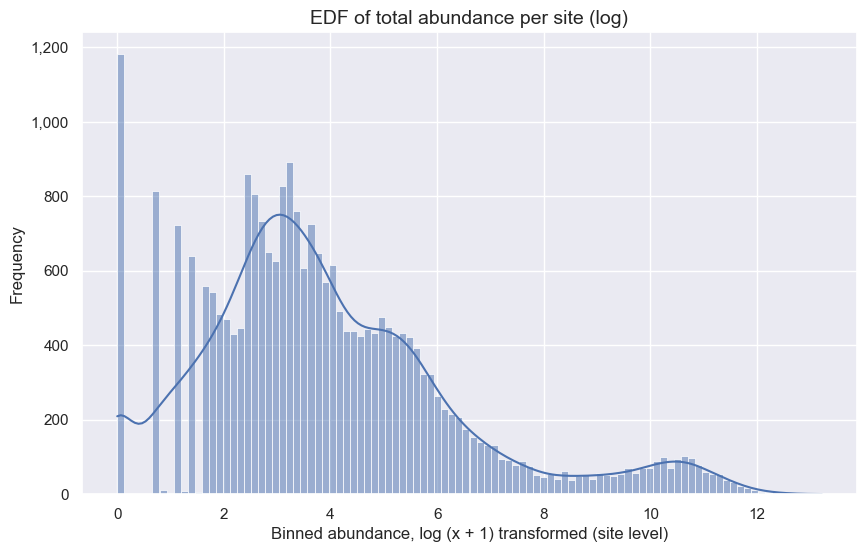

In [78]:
# Perform log(x + 1) transformation of abundance numbers
df_ind_count_log = df_ind_count_per_site.with_columns(
    (pl.col("Tot_abundance").map_elements(lambda x: np.log(x + 1))).alias(
        "Tot_abundance_log"
    )
)

plot_histogram_with_density(
    df_ind_count_log,
    data_col="Tot_abundance_log",
    title="EDF of total abundance per site (log)",
    xlabel="Binned abundance, log (x + 1) transformed (site level)",
    bins=100,
    kde=True,
)

### Capped count of individuals 

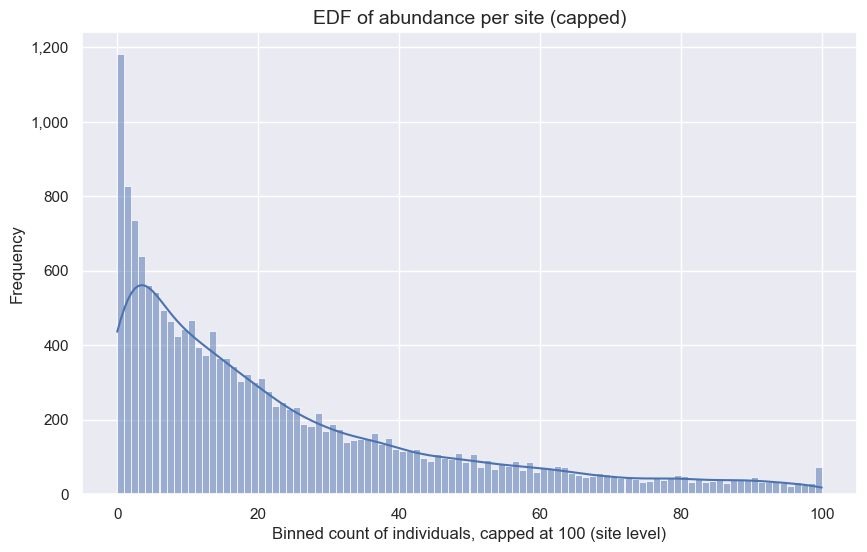

In [79]:
# Perform similar analysis, but instead of log transform, filter out large values
upper_lim = 100

# Filter data for upper limit
df_ind_count_lim = df_ind_count_per_site.filter(pl.col("Tot_abundance") <= upper_lim)

plot_histogram_with_density(
    df_ind_count_lim,
    data_col="Tot_abundance",
    title="EDF of abundance per site (capped)",
    xlabel=f"Binned count of individuals, capped at {upper_lim} (site level)",
    bins=100,
    kde=True,
)

**Comment:** Untransformed count data is approx Poisson, but possibly with a higher frequency of zeros than the standard model would assume. 

### Abundance data dispersion

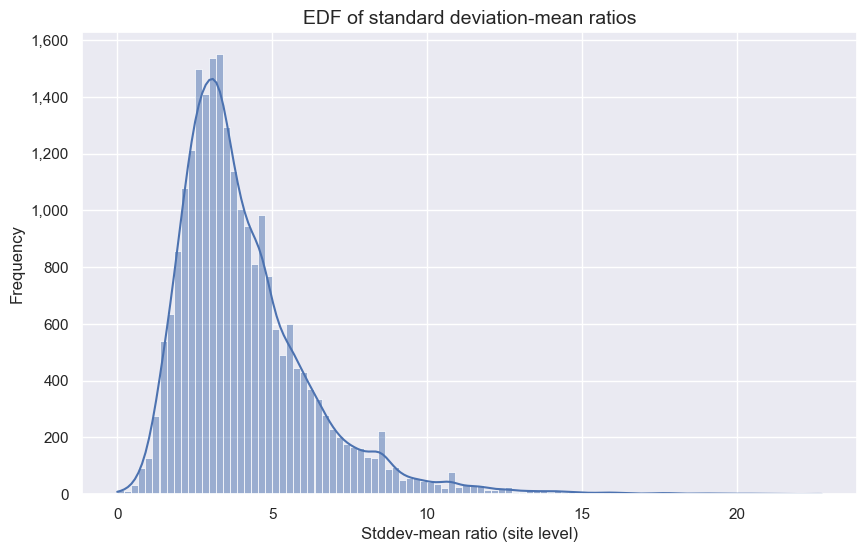

In [80]:
# Calculate std-mean ratio
df_std_mean_ratio = df_agg_stats.drop_nulls()
df_std_mean_ratio = df_std_mean_ratio.with_columns(
    (pl.col("std") / pl.col("mean")).alias("Std_mean_ratio")
)

plot_histogram_with_density(
    df_std_mean_ratio,
    data_col="Std_mean_ratio",
    title="EDF of standard deviation-mean ratios",
    xlabel="Stddev-mean ratio (site level)",
    bins=100,
    kde=True,
)

**Comment:** If we compare to a Poisson model, which assumes equal mean and variance, the data is highly overdispersed. That would speak in favor for using a Negative-Binomial distribution for count data. Still there are a few instances where data is underdispersed. Additionally, there are big differences in mean-variance ratio between sites.

## Abundance-based diversity measures

### Shannon diversity index

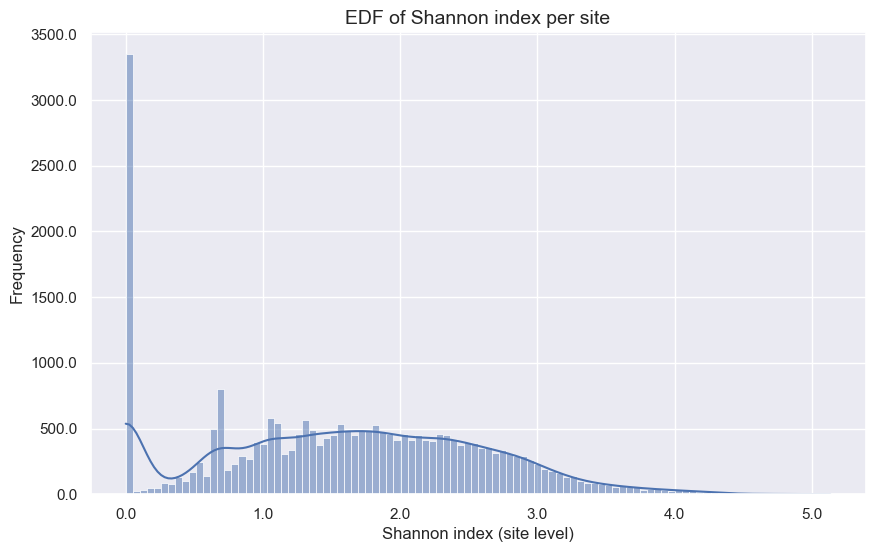

In [81]:
# Calculating abundance per species
df_species_abundance = df_abund_ind.group_by(["SS", "SSBS", "Taxon_name_entered"]).agg(
    pl.sum("Effort_corrected_measurement").alias("Species_abundance")
)

# Adding total abundance per site
df_species_abundance = df_species_abundance.join(
    df_species_abundance.group_by(["SS", "SSBS"]).agg(
        pl.sum("Species_abundance").alias("Site_abundance"),
        pl.n_unique("Taxon_name_entered").alias(
            "Taxon_count"
        ),  # Add taxon count for single-taxon check
    ),
    on=["SS", "SSBS"],
)

# Calculating relative abundance
df_species_abundance = df_species_abundance.with_columns(
    pl.when(pl.col("Site_abundance") == 0)
    .then(0)
    .otherwise(pl.col("Species_abundance") / pl.col("Site_abundance"))
    .alias("Relative_abundance")
)

# Calculating Shannon component per species with explicit handling for single-taxon sites
df_species_abundance = df_species_abundance.with_columns(
    pl.when(pl.col("Taxon_count") == 1)  # Explicitly handle single-taxon sites
    .then(0)
    .when(pl.col("Relative_abundance") == 0)
    .then(0)
    .otherwise(
        -pl.col("Relative_abundance") * pl.col("Relative_abundance").log().fill_nan(0)
    )
    .alias("Shannon_component")
)

# Sum up the Shannon components to get the index for each site
df_shannon = df_species_abundance.group_by(["SS", "SSBS"]).agg(
    pl.sum("Shannon_component").alias("Shannon_index")
)

plot_histogram_with_density(
    df_shannon,
    data_col="Shannon_index",
    title="EDF of Shannon index per site",
    xlabel="Shannon index (site level)",
    bins=100,
    kde=True,
)

In [82]:
# Count occurrences where Shannon index is exactly 0
shannon_exact_zero = df_shannon.filter(pl.col("Shannon_index") == 0).shape[0]
print(f"Number of sites with Shannon index exactly 0: {shannon_exact_zero}")

Number of sites with Shannon index exactly 0: 3336


In [83]:
df_shannon.head()

shape: (5, 3)
┌──────────────────────┬────────────────────────────┬───────────────┐
│ SS                   ┆ SSBS                       ┆ Shannon_index │
│ ---                  ┆ ---                        ┆ ---           │
│ str                  ┆ str                        ┆ f64           │
╞══════════════════════╪════════════════════════════╪═══════════════╡
│ AD1_2008__Billeter 8 ┆ AD1_2008__Billeter 8 F3 40 ┆ 2.303166      │
│ AD1_2008__Billeter 9 ┆ AD1_2008__Billeter 9 G1 13 ┆ 2.145611      │
│ AD1_2008__Billeter 9 ┆ AD1_2008__Billeter 9 G1 14 ┆ 1.978048      │
│ AD1_2008__Billeter 9 ┆ AD1_2008__Billeter 9 G2 22 ┆ 1.386294      │
│ AD1_2008__Billeter 9 ┆ AD1_2008__Billeter 9 G3 37 ┆ 1.961521      │
└──────────────────────┴────────────────────────────┴───────────────┘

In [ ]:
df_shannon = df_shannon.join(
    df_predicts.select(["SSBS", "Predominant_land_use"]), on="SSBS", how="inner"
)

plot_violin(
    df_shannon, 
    data_col="Shannon_index",
    title="Shannon index distribution per land use class",
    category_col="Predominant_land_use",
)

### Gini-Simpson diversity index

In [ ]:
# Gini-Simpson Index
df_species_abundance = df_species_abundance.with_columns(
    (pl.col("Relative_abundance") ** 2).alias("Simpson_component")
)

df_simpson = df_species_abundance.group_by(["SS", "SSBS"]).agg(
    pl.sum("Simpson_component").alias("Lambda")
)

# Reuse site abundance and taxon count for Simpson index
df_simpson = df_simpson.join(
    df_species_abundance.group_by(["SS", "SSBS"]).agg(
        pl.sum("Site_abundance").alias("Site_abundance"),
        pl.n_unique("Taxon_name_entered").alias("Taxon_count"),
    ),
    on=["SS", "SSBS"],
)

df_simpson = df_simpson.with_columns(
    pl.when(pl.col("Site_abundance") == 0)  # Zero-abundance sites
    .then(0)
    .when(pl.col("Taxon_count") == 1)  # Single-taxon sites
    .then(0)
    .otherwise(1 - pl.col("Lambda"))  # 1 - lambda for other cases
    .alias("Simpson_index")
)

# Plot Simpson
plot_histogram_with_density(
    df_simpson,
    data_col="Simpson_index",
    title="EDF of Simpson index per site",
    xlabel="Simpson index (site level)",
    bins=100,
    kde=True,
)

In [ ]:
# Count occurrences where Simpson index is exactly 1
simpson_exact_zero = df_simpson.filter(pl.col("Simpson_index") == 0).shape[0]
print(f"Number of sites with Simpson index exactly 0: {simpson_exact_zero}")

In [ ]:
# Count number of taxons per site
df_taxon_count = df_abund_ind.group_by(["SS", "SSBS"]).agg(
    pl.n_unique("Taxon_name_entered").alias("Taxon_count")
)

# Count sites where the number of taxons is 1
single_taxon_sites = df_taxon_count.filter(pl.col("Taxon_count") == 1).shape[0]
print(f"Number of sites with only one taxon: {single_taxon_sites}")

# Calculate total abundance per site
df_site_abundance = df_abund_ind.group_by(["SS", "SSBS"]).agg(
    pl.sum("Effort_corrected_measurement").alias("Total_abundance")
)

# Count sites where total abundance is 0
zero_abundance_sites = df_site_abundance.filter(pl.col("Total_abundance") == 0).shape[0]
print(f"Number of sites with total abundance of 0: {zero_abundance_sites}")

### Some simple simulation of the two indices

In [ ]:
counts = np.array([1, 2, 3, 4, 5])  # [5, 5, 5, 5, 5]  [1, 2, 3, 4, 5]
rel_counts = counts / np.sum(counts)
print(rel_counts)

print("Shannon")
shannon_comp = rel_counts * np.log(rel_counts)
print(shannon_comp)
shannon = -np.sum(shannon_comp)
print(shannon)

print("Simpson")
simpson_comp = np.square(rel_counts)
print(simpson_comp)
simpson = 1 - np.sum(simpson_comp)
print(simpson)

In [ ]:
counts = np.array([5, 5])  # [5, 5]  [1, 2]
rel_counts = counts / np.sum(counts)
print(rel_counts)

print("Shannon")
shannon_comp = rel_counts * np.log(rel_counts)
print(shannon_comp)
shannon = -np.sum(shannon_comp)
print(shannon)

print("Simpson")
simpson_comp = np.square(rel_counts)
print(simpson_comp)
simpson = 1 - np.sum(simpson_comp)
print(simpson)

In [ ]:
counts = np.array(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
)  # [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rel_counts = counts / np.sum(counts)
print(rel_counts)

print("Shannon")
shannon_comp = rel_counts * np.log(rel_counts)
print(shannon_comp)
shannon = -np.sum(shannon_comp)
print(shannon)

print("Simpson")
simpson_comp = np.square(rel_counts)
print(simpson_comp)
simpson = 1 - np.sum(simpson_comp)
print(simpson)

## Data normalization

### Richness: Max scaling (maximum within study)

In [ ]:
# Calculate the max richness within each study
df_max_richness = df_richness_per_site.group_by(["SS"]).agg(
    pl.max("Tot_richness").alias("Max_richness")
)

df_max_richness_scaled = df_richness_per_site.join(
    df_max_richness, on="SS", how="left", validate="m:1"
)

# Perform max scaling of site-level richness
df_max_richness_scaled = df_max_richness_scaled.with_columns(
    (pl.col("Tot_richness") / pl.col("Max_richness")).alias("Richness_max_scaled")
)

plot_histogram_with_density(
    df_max_richness_scaled,
    data_col="Richness_max_scaled",
    title="EDF of max scaled species richness per site",
    xlabel="Binned scaled richness (site level)",
    bins=100,
    kde=True,
)

### Richness: Standardization

In [ ]:
df_richness_stats = df_richness_per_site.group_by("SS").agg(
    [
        pl.mean("Tot_richness").alias("Mean_richness"),
        pl.std("Tot_richness").alias("Std_richness"),
    ]
)

# Join the stats back to the original DataFrame
df_richness_standard = df_richness_per_site.join(
    df_richness_stats, on="SS"
).with_columns(
    (
        pl.when(pl.col("Std_richness") != 0)
        .then(
            (pl.col("Tot_richness") - pl.col("Mean_richness")) / pl.col("Std_richness")
        )
        .otherwise(0)
    ).alias("Standardized_richness")
)

plot_histogram_with_density(
    df_richness_standard,
    data_col="Standardized_richness",
    title="EDF of standardized species richness per site",
    xlabel="Binned scaled richness (site level)",
    bins=100,
    kde=True,
)

### Richness: Standardization + min-max scaling

In [ ]:
df_richness_standard_stats = df_richness_standard.group_by("SS").agg(
    [
        pl.min("Standardized_richness").alias("Min_standard_richness"),
        pl.max("Standardized_richness").alias("Max_standard_richness"),
    ]
)

# Join the stats back to the original DataFrame
df_richness_standard_minmax = df_richness_standard.join(
    df_richness_standard_stats, on="SS"
).with_columns(
    (
        (pl.col("Standardized_richness") - pl.col("Min_standard_richness"))
        / (pl.col("Max_standard_richness") - pl.col("Min_standard_richness"))
    ).alias("Standardized_richness_minmax")
)

plot_histogram_with_density(
    df_richness_standard_minmax,
    data_col="Standardized_richness_minmax",
    title="EDF of standardized species richness per site",
    xlabel="Binned scaled richness (site level)",
    bins=100,
    kde=True,
)

### Richness: Log + standardization + max scaling

In [ ]:
df_richness_per_site_log = df_richness_per_site.with_columns(
    (pl.col("Tot_richness") + 1).log().alias("Tot_richness_log")
)

df_richness_stats_log = df_richness_per_site_log.group_by("SS").agg(
    [
        pl.mean("Tot_richness_log").alias("Mean_richness_log"),
        pl.std("Tot_richness_log").alias("Std_richness_log"),
    ]
)

# Join the stats back to the original DataFrame
df_richness_standard_log = df_richness_per_site_log.join(
    df_richness_stats_log, on="SS"
).with_columns(
    (
        pl.when(pl.col("Std_richness_log") != 0)
        .then(
            (pl.col("Tot_richness_log") - pl.col("Mean_richness_log"))
            / pl.col("Std_richness_log")
        )
        .otherwise(0)
    ).alias("Standardized_richness_log")
)

dataset_min = df_richness_standard_log.select("Standardized_richness_log").min().item()
dataset_max = df_richness_standard_log.select("Standardized_richness_log").max().item()

# Join the stats back to the original DataFrame
df_richness_standard_log_scaled = df_richness_standard_log.with_columns(
    (
        (pl.col("Standardized_richness_log") + abs(dataset_min))
        / (abs(dataset_min) + abs(dataset_max))
    ).alias("Standardized_richness_log_scaled")
)

plot_histogram_with_density(
    df_richness_standard_log_scaled,
    data_col="Standardized_richness_log_scaled",
    title="EDF of log + standardized + scaled species richness per site",
    xlabel="Binned normalized richness (site level)",
    bins=100,
    kde=True,
)

### Abundance: Standard min-max scaling

This includes all abundance measurements, not just the ones reported as counts of individuals.

In [ ]:
# Calculate the total abundance for each site, grouped by study
df_study_site_abund = df_abundance.group_by(["SS", "SSBS"]).agg(
    pl.sum("Effort_corrected_measurement").alias("Site_abundance")
)

# Calculate the min and max total abundance within each study
df_study_min_max = df_study_site_abund.group_by("SS").agg(
    [
        pl.min("Site_abundance").alias("Min_abundance"),
        pl.max("Site_abundance").alias("Max_abundance"),
    ]
)

# Join the two dataframes on "SS" and perform min-max scaling
df_study_site_scaled = df_study_site_abund.join(df_study_min_max, on="SS").with_columns(
    (
        (pl.col("Site_abundance") - pl.col("Min_abundance"))
        / (pl.col("Max_abundance") - pl.col("Min_abundance"))
    ).alias("Abundance_minmax_scaled")
)

plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Abundance_minmax_scaled",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Binned min-max (0-1) scaled abundance (site level)",
    bins=100,
    kde=True,
)

### Abundance: Max scaling (maximum within study)

In [ ]:
df_study_site_scaled = df_study_site_scaled.with_columns(
    (pl.col("Site_abundance") / pl.col("Max_abundance")).alias("Abundance_max_scaled")
)

plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Abundance_max_scaled",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Binned scaled abundance (0-1), site / study max (site level)",
    bins=100,
    kde=True,
)

**Comment:** This should be possible to approximate with a zero-one inflated Beta regression. The BII version is less zero-inflated than using min-max scaling, which could be a benefit. The analysis below is based on this measure.

In [ ]:
# Check percentage of exact 0s and 1s in the data
# Total number of observations
total_obs = df_study_site_scaled.height

# Calculate percentages for min-max scaled abundance
min_max_zeros = (
    df_study_site_scaled.filter(pl.col("Abundance_minmax_scaled") == 0).height
    / total_obs
)
min_max_ones = (
    df_study_site_scaled.filter(pl.col("Abundance_minmax_scaled") == 1).height
    / total_obs
)

# Calculate percentages for max scaled abundance
max_zeros = (
    df_study_site_scaled.filter(pl.col("Abundance_max_scaled") == 0).height / total_obs
)
max_ones = (
    df_study_site_scaled.filter(pl.col("Abundance_max_scaled") == 1).height / total_obs
)

# Print results with descriptions
print(f"Percentage of exact 0s in Abundance_minmax_scaled: {min_max_zeros:.2%}")
print(f"Percentage of exact 1s in Abundance_minmax_scaled: {min_max_ones:.2%}")
print(f"Percentage of exact 0s in Abundance_max_scaled: {max_zeros:.2%}")
print(f"Percentage of exact 1s in Abundance_max_scaled: {max_ones:.2%}")

### Abundance: Standardization

In [ ]:
df_abundance_stats = df_study_site_abund.group_by("SS").agg(
    [
        pl.mean("Site_abundance").alias("Mean_abundance"),
        pl.std("Site_abundance").alias("Std_abundance"),
    ]
)

# Join the stats back to the original DataFrame
df_abundance_standard = df_study_site_abund.join(
    df_abundance_stats, on="SS"
).with_columns(
    (
        (pl.col("Site_abundance") - pl.col("Mean_abundance")) / pl.col("Std_abundance")
    ).alias("Standardized_abundance")
)

plot_histogram_with_density(
    df_abundance_standard,
    data_col="Standardized_abundance",
    title="EDF of standardized species abundance per site",
    xlabel="Binned scaled abundance (site level)",
    bins=100,
    kde=True,
)

In [ ]:
df_abundance_per_site_log = df_study_site_abund.with_columns(
    (pl.col("Site_abundance") + 1).log().alias("Site_abundance_log")
)

df_abundance_stats_log = df_abundance_per_site_log.group_by("SS").agg(
    [
        pl.mean("Site_abundance_log").alias("Mean_abundance_log"),
        pl.std("Site_abundance_log").alias("Std_abundance_log"),
    ]
)

# Join the stats back to the original DataFrame
df_abundance_standard_log = df_abundance_per_site_log.join(
    df_abundance_stats_log, on="SS"
).with_columns(
    (
        pl.when(pl.col("Std_abundance_log") != 0)
        .then(
            (pl.col("Site_abundance_log") - pl.col("Mean_abundance_log"))
            / pl.col("Std_abundance_log")
        )
        .otherwise(0)  # Replace with NaN or other default
    ).alias("Standardized_abundance_log")
)

dataset_min = (
    df_abundance_standard_log.select("Standardized_abundance_log").min().item()
)
dataset_max = (
    df_abundance_standard_log.select("Standardized_abundance_log").max().item()
)

# Join the stats back to the original DataFrame
df_abundance_standard_log_scaled = df_abundance_standard_log.with_columns(
    (
        (pl.col("Standardized_abundance_log") + abs(dataset_min))
        / (abs(dataset_min) + abs(dataset_max))
    ).alias("Standardized_abundance_log_scaled")
)

plot_histogram_with_density(
    df_abundance_standard_log_scaled,
    data_col="Standardized_abundance_log_scaled",
    title="EDF of log + standardized + scaled species abundance per site",
    xlabel="Binned normalized abundance (site level)",
    bins=100,
    kde=True,
)

### Abundance: Transformation of the max scaled variable

The authors of BII apply a square-root transformation to the scaled data, then assume that residuals are Gaussian. They also tried a logit transformation (for compositional similarity). We compare both approaches below.

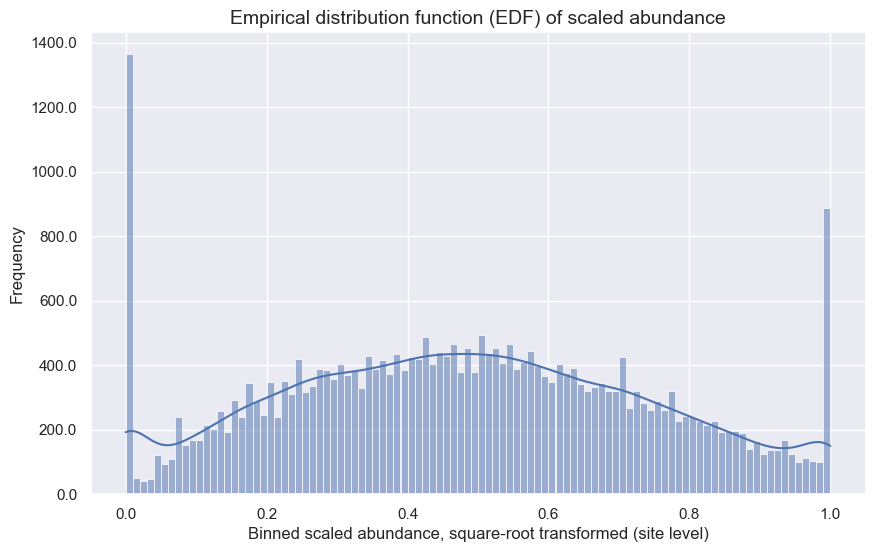

In [354]:
# Do square-root transformation of the scaled data
df_study_site_scaled = df_study_site_scaled.with_columns(
    pl.col("Abundance_max_scaled").sqrt().alias("Abundance_max_scaled_sqrt")
)

plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Abundance_max_scaled_sqrt",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Binned scaled abundance, square-root transformed (site level)",
    bins=100,
    kde=True,
)

**Comment:** This could be approximated with a zero-one inflated Beta or logit-Normal distribution. While a transformation on top of a transformation might not be ideal, we can try if sqrt improves the model fit and predictions.

In [317]:
# Do logit transformation of the scaled data
def logit(abund):
    adjust = 0.001

    if abund == 0:
        res = scipy.special.logit(abund + adjust)
    elif abund == 1:
        res = scipy.special.logit(abund - adjust)
    else:
        res = scipy.special.logit(abund - adjust)

    return res

In [ ]:
adjust = 0.001
    original_col_name = "Max_scaled_abundance"
    transformed_col_name = original_col_name

    # Small adjustment to align with support for Beta distribution
    if method == "adjust" or method == "logit":
        df = df.with_columns(
            pl.when(pl.col(original_col_name) == 0)
            .then(adjust)
            .when(pl.col(original_col_name) == 1)
            .then(1 - adjust)
            .otherwise(pl.col(original_col_name))
            .alias(original_col_name)
        )
        if method == "logit":
            transformed_col_name += "_logit"
            df = df.with_columns(
                pl.col(original_col_name)
                .map_elements(lambda x: logit(x))
                .alias(transformed_col_name)
            )

In [318]:
df_study_site_scaled = df_study_site_scaled.copy()
df_study_site_scaled["Scaled_abund_logit"] = df_study_site_scaled[
    "Abundance_scaled_BII"
].apply(lambda row: logit(row))

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


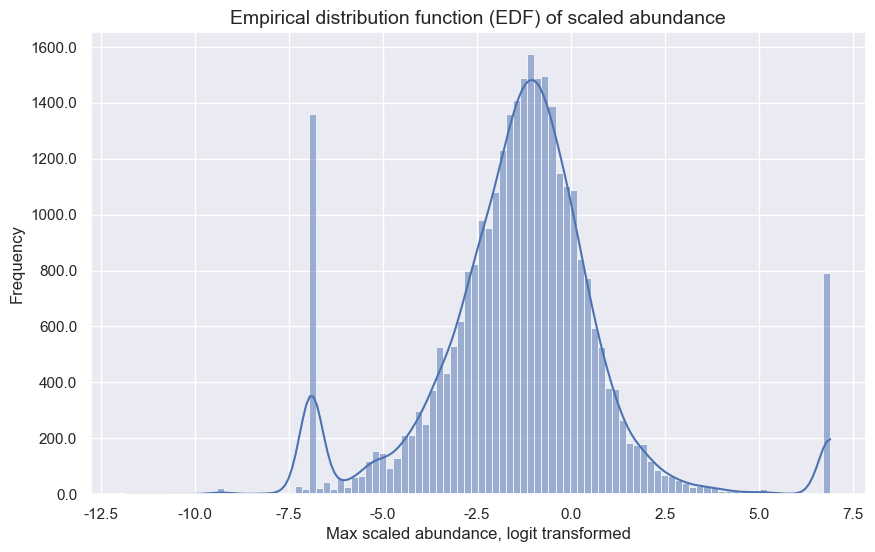

In [319]:
plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Scaled_abund_logit",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Max scaled abundance, logit transformed",
    bins=100,
    kde=True,
)

### Alternative scaling approach: Average scaling

To avoid the inflation of ones, we divide each abundance with the within-study average.

In [280]:
# Calculate the max and min total abundance within each study
df_study_mean = (
    df_study_site_abund.groupby("SS")["Site_abundance"]
    .mean()
    .reset_index()
    .rename(columns={"Site_abundance": "Mean_abundance"})
)

In [281]:
# Join the new column to the existing dataframe
df_study_site_scaled = df_study_site_scaled.join(
    df_study_mean.set_index("SS"), on="SS", how="left", validate="m:1"
)

# Calculate the new scaled numbers
df_study_site_scaled["Abundance_scaled_mean"] = (
    abund / df_study_site_scaled["Mean_abundance"]
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


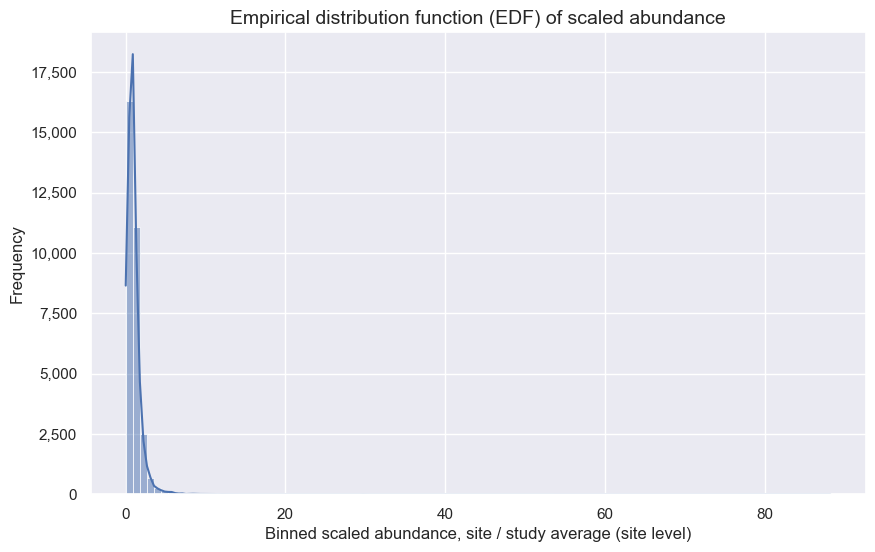

In [301]:
plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Abundance_scaled_mean",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Binned scaled abundance, site / study average (site level)",
    bins=100,
    kde=True,
)

### Transformations of the average-scaled data

In [283]:
df_study_site_scaled = df_study_site_scaled.copy()

# Log
df_study_site_scaled["Scaled_abund_mean_log"] = np.log(
    df_study_site_scaled["Abundance_scaled_mean"] + 1
)

# Square-root
df_study_site_scaled = df_study_site_scaled.copy()
df_study_site_scaled["Scaled_abund_mean_sqrt"] = np.sqrt(
    df_study_site_scaled["Abundance_scaled_mean"]
)
# Cube-root
df_study_site_scaled = df_study_site_scaled.copy()
df_study_site_scaled["Scaled_abund_mean_cbrt"] = np.cbrt(
    df_study_site_scaled["Abundance_scaled_mean"]
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


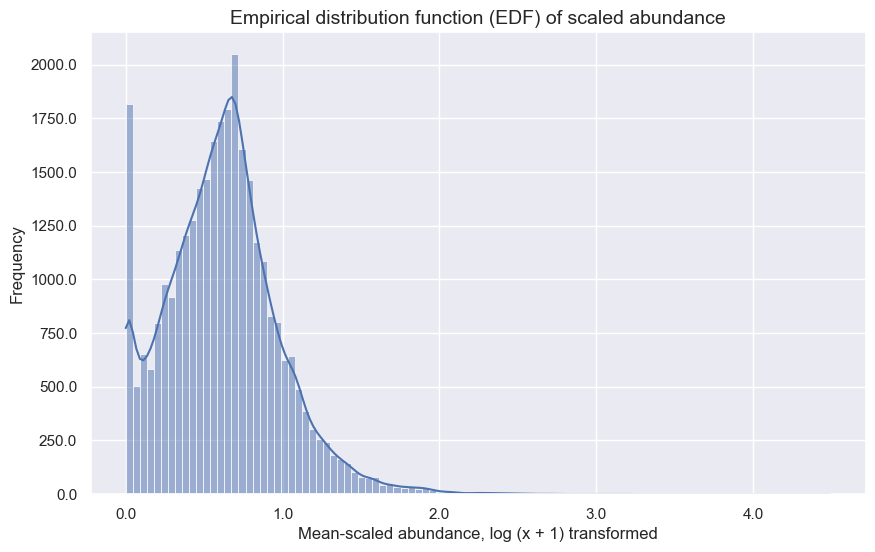

In [302]:
plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Scaled_abund_mean_log",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Mean-scaled abundance, log (x + 1) transformed",
    bins=100,
    kde=True,
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


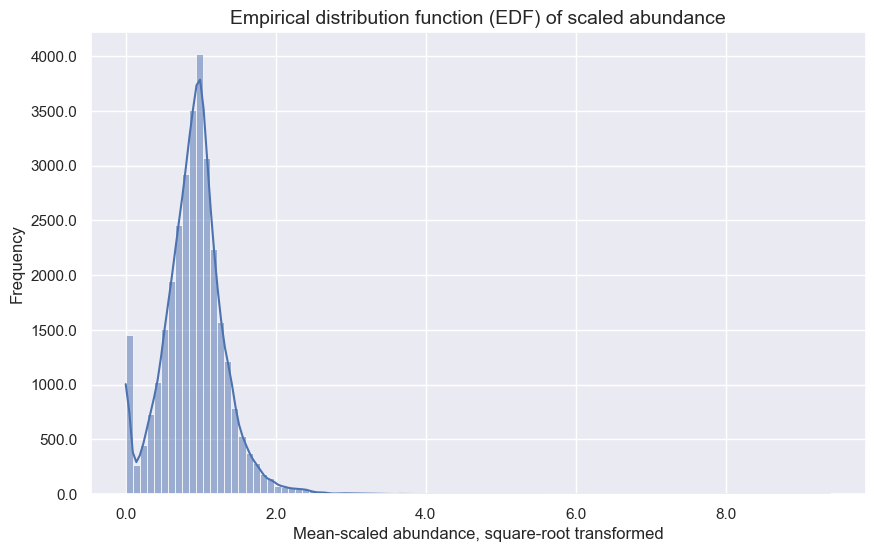

In [303]:
plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Scaled_abund_mean_sqrt",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Mean-scaled abundance, square-root transformed",
    bins=100,
    kde=True,
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


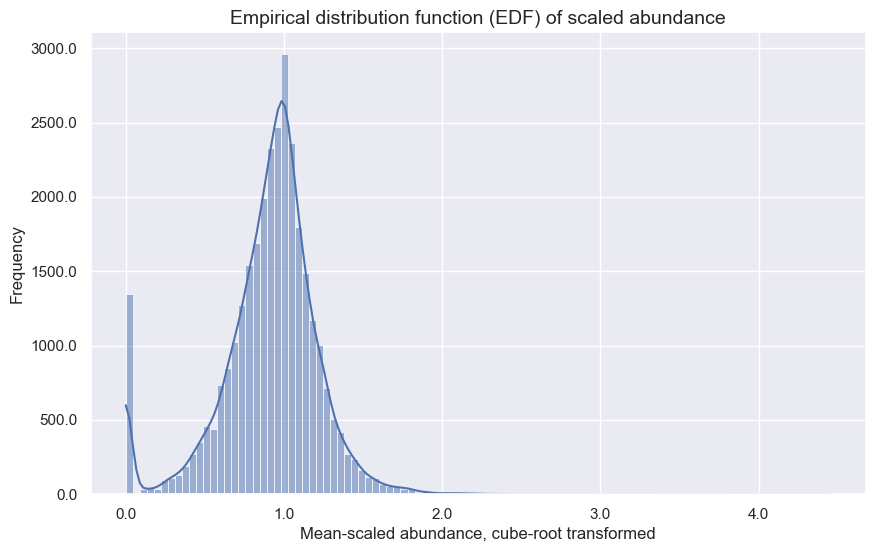

In [304]:
plot_histogram_with_density(
    df_study_site_scaled,
    data_col="Scaled_abund_mean_cbrt",
    title="Empirical distribution function (EDF) of scaled abundance",
    xlabel="Mean-scaled abundance, cube-root transformed",
    bins=100,
    kde=True,
)

## Distribution of compositional similarity

In [320]:
# Load the complete data set, this time using polars
df_predicts = pl.read_csv("../../data/PREDICTS/merged_data.csv")

In [321]:
df_abundance = df_predicts.filter(pl.col("Diversity_metric_type") == "Abundance")

In [322]:
# Identify studies with consistent sampling effort across sites
single_effort_studies = (
    df_abundance.group_by("SS")
    .agg(pl.col("Sampling_effort").n_unique().alias("unique_effort"))
    .filter(pl.col("unique_effort") == 1)
    .get_column("SS")
    .to_list()
)

In [323]:
# Identify studies where at least one site is minimally-used primary vegetation
min_primary_studies = (
    df_abundance.filter(
        (pl.col("Predominant_land_use") == "Primary vegetation")
        & (pl.col("Use_intensity") == "Minimal use")
    )
    .get_column("SS")
    .unique()
    .to_list()
)

In [324]:
# Identify studies with more than one taxon surveyed
multi_taxa_studies = (
    df_abundance.group_by("SS")
    .agg(pl.col("Taxon_name_entered").n_unique().alias("unique_taxon"))
    .filter(pl.col("unique_taxon") > 1)
    .get_column("SS")
    .unique()
    .to_list()
)

In [118]:
# Filter the original dataframe for all of these criteria
studies_to_include = list(
    set(single_effort_studies) & set(min_primary_studies) & set(multi_taxa_studies)
)
df_similarity_calc = df_abundance.filter(pl.col("SS").is_in(studies_to_include))
len(studies_to_include)

244

In [149]:
# List of all studies, and list for storing results
studies = df_similarity_calc.get_column("SS").unique().to_list()
results = []

start = time.time()

# Iterate through all studies
for study in studies:
    df_study = df_similarity_calc.filter((pl.col("SS") == study)).lazy()
    results = pairwise_similarity_scores(study, df_study, results)

end = time.time()
print(end - start)

# Create a dataframe from the output of all site pairs
df_comp_similarity = pl.DataFrame(results)

968.3015460968018


In [150]:
df_comp_similarity.shape

(586660, 4)

In [142]:
def pairwise_similarity_scores(study, df, results):

    # Get a list of all minimal-primary sites
    min_primary_sites = (
        df.filter(
            (pl.col("Predominant_land_use") == "Primary vegetation")
            & (pl.col("Use_intensity") == "Minimal use")
        )
        .collect()
        .get_column("SSBS")
        .unique()
        .to_list()
    )
    # Then get a list of all the sites
    all_sites = df.collect().get_column("SSBS").unique().to_list()

    # Apply the Bray-Curtis function to every pair of sites
    for site_1 in min_primary_sites:
        for site_2 in all_sites:
            if site_1 != site_2:
                score = calculate_bray_curtis(df, study, site_1, site_2)
                results.append(score)
            else:
                continue

    return results

In [144]:
def calculate_bray_curtis(
    df: pd.DataFrame, study: str, site_1: str, site_2: str
) -> dict:
    """
    Calculate the Bray-Curtis similarity metric between a pair of sites
    from the same study.

    Args:
        df (pd.DataFrame): Dataframe filtered for the study in question.
        study (str): The study being evaluated.
        site_1 (str): A minimally-used primary vegation site from the study.
        site_2 (str): Any other site in that study.

    Returns
        bray_curtis_output (dict): Dictionary with the Bray-Curtis score of
        the two sites, and IDs for the study and sites.
    """

    # Create two dataframes with required information about both sites
    # Since sampling effort is consistent, we use raw Measurement
    df_site_1 = (
        df.filter(pl.col("SSBS") == site_1)
        .select(["SSBS", "Taxon_name_entered", "Measurement"])
        .sort("Taxon_name_entered")
        .collect()
    )
    df_site_2 = (
        df.filter(pl.col("SSBS") == site_2)
        .select(["SSBS", "Taxon_name_entered", "Measurement"])
        .sort("Taxon_name_entered")
        .collect()
    )

    # Calculate the total abundance of each site
    s1_tot_abund = df_site_1.get_column("Measurement").sum()
    s2_tot_abund = df_site_2.get_column("Measurement").sum()

    # Handle cases where one or both sites have zero abundance
    if s1_tot_abund == 0 and s2_tot_abund == 0:
        bray_curtis = np.nan
    elif s1_tot_abund == 0 or s2_tot_abund == 0:
        bray_curtis = 0

    # Case where both sites have abundance values
    else:
        # Get lists of taxons for each site
        s1_taxa = df_site_1.get_column("Taxon_name_entered").to_list()
        s2_taxa = df_site_2.get_column("Taxon_name_entered").to_list()

        # Check if the list of taxons are identical
        # Then we can directly convert measurements to a numpy array
        if set(s1_taxa) == set(s2_taxa) and len(df_site_1) == len(df_site_2):
            pairwise_abundance = np.column_stack(
                (
                    df_site_1.get_column("Measurement"),
                    df_site_2.get_column("Measurement"),
                )
            )

        # Otherwise we need to do a merge of dataframes first
        else:
            # Do an outer merge on taxon name and fill any non-overlapping taxons with zeros
            df_merged = df_site_1.join(
                df_site_2,
                on="Taxon_name_entered",
                how="outer",
                suffix="_site2",
            )
            df_merged = df_merged.fill_nan(0)

            # Covert to numpy array
            pairwise_abundance = np.column_stack(
                (
                    df_merged.get_column("Measurement"),
                    df_merged.get_column("Measurement_site2"),
                ),
            )

        # Calculate the sum of pair-wise minimum abundance
        min_abundance_sum = np.sum(np.min(pairwise_abundance, axis=1))

        # Calculate the similarity version of the Bray-Curtis dissimilarity metric
        # A value of 1 means that the two sites are identical in composition
        bray_curtis = (2 * min_abundance_sum) / (s1_tot_abund + s2_tot_abund)

    # Create and output dictionary
    bray_curtis_output = {
        "SS": study,
        "Primary_minimal_site": site_1,
        "Other_site": site_2,
        "Similarity_score": bray_curtis,
    }

    return bray_curtis_output

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


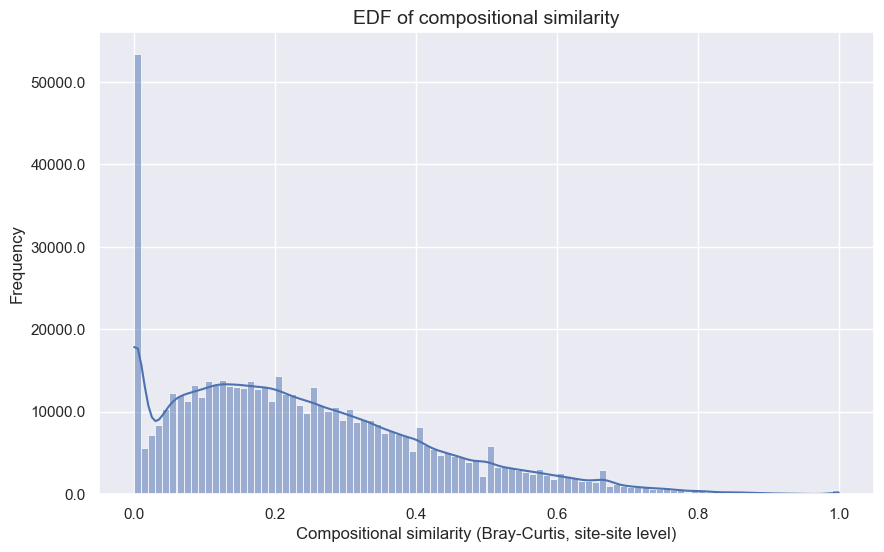

In [325]:
plot_histogram_with_density(
    df_comp_similarity,
    data_col="Similarity_score",
    title="EDF of compositional similarity",
    xlabel="Compositional similarity (Bray-Curtis, site-site level)",
    bins=100,
    kde=True,
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


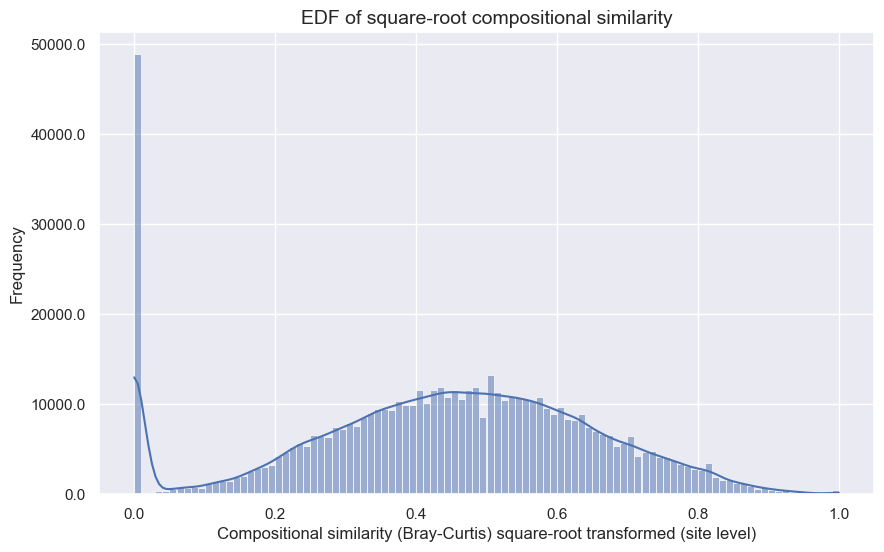

In [326]:
# Do a square-root transformation of the similarity scores
df_comp_similarity = df_comp_similarity.with_columns(
    np.sqrt(pl.col("Similarity_score")).alias("Similarity_score_sqrt")
)

plot_histogram_with_density(
    df_comp_similarity,
    data_col="Similarity_score_sqrt",
    title="EDF of square-root compositional similarity",
    xlabel="Compositional similarity (Bray-Curtis) square-root transformed (site level)",
    bins=100,
    kde=True,
)

**Comment**: Similar distribution as abundance, except that there is not one-inflation. 

The BII authors actually used a logit transformation of the compositional similarity, which we try below.

In [334]:
df_comp_similarity = df_comp_similarity.drop("Similarity_score_logit")

In [335]:
# Do a logit transformation of the similarity scores
df_comp_similarity = df_comp_similarity.with_columns(
    pl.col("Similarity_score")
    .map_elements(lambda x: logit(x))
    .alias("Similarity_score_logit")
)

/Users/jakobnystrom/anaconda3/envs/biodiv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


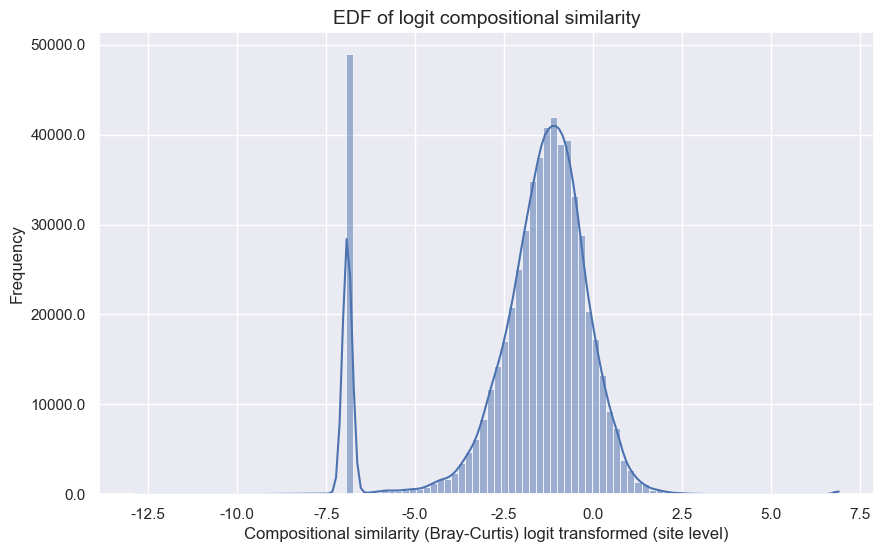

In [336]:
plot_histogram_with_density(
    df_comp_similarity,
    data_col="Similarity_score_logit",
    title="EDF of logit compositional similarity",
    xlabel="Compositional similarity (Bray-Curtis) logit transformed (site level)",
    bins=100,
    kde=True,
)